In [2]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmpfs/tmp/pip-req-build-hutog_tg
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmpfs/tmp/pip-req-build-hutog_tg


  Resolved https://github.com/tensorflow/examples.git to commit 0bbf4fe43fbf41b7174b9ce4a64d69bd33aadd21


  Preparing metadata (setup.py) ... -

 done


 \

 done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1689703202.67065300351684276117070052891639684042406419745-py3-none-any.whl size=301556 sha256=cc61daaa737b09963ed7e8ecb299de3449ad9731addff736b64000677c748348
  Stored in directory: /tmpfs/tmp/pip-ephem-wheel-cache-h0al1ils/wheels/08/f6/82/53a5b86c72bceebba962022c76037c95a9b2912f0719e5b9d2
Successfully built tensorflow-examples


In [3]:
import tensorflow as tf

import tensorflow_datasets as tfds

In [4]:
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

## Download the Oxford-IIIT Pets dataset


In [5]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [6]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [7]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [8]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [9]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [10]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
  
  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [11]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

In [12]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


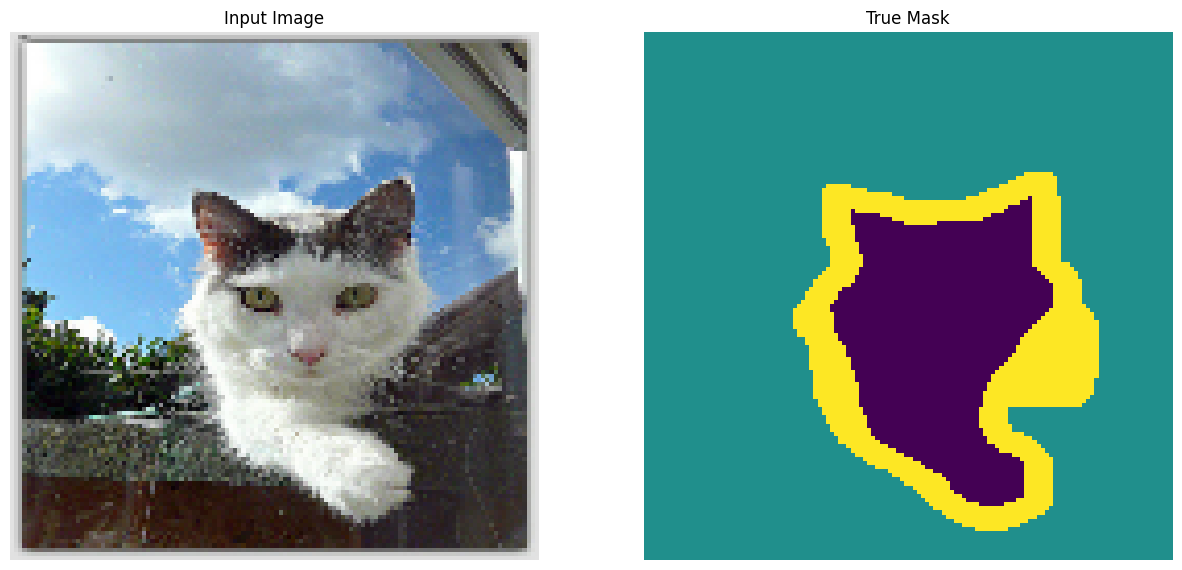

2023-07-27 06:01:20.938788: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


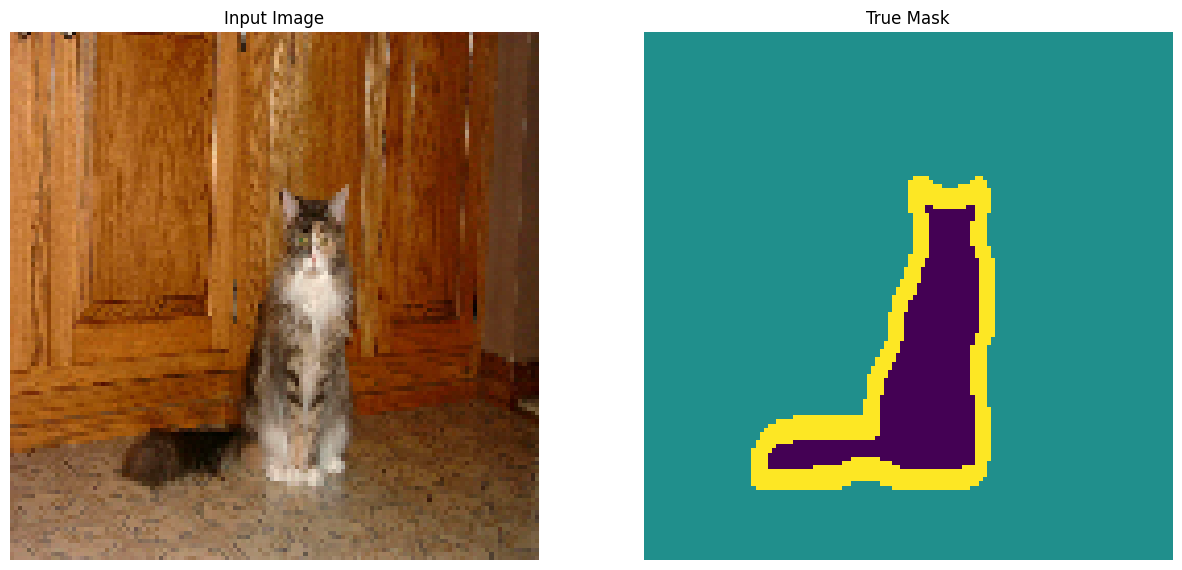

In [13]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

## Define the model
The model being used here is a modified [U-Net](https://arxiv.org/abs/1505.04597). A U-Net consists of an encoder (downsampler) and decoder (upsampler). To learn robust features and reduce the number of trainable parameters, use a pretrained model—[MobileNetV2](https://arxiv.org/abs/1801.04381)—as the encoder. For the decoder, you will use the upsample block, which is already implemented in the [pix2pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) example in the TensorFlow Examples repo. (Check out the [pix2pix: Image-to-image translation with a conditional GAN](../generative/pix2pix.ipynb) tutorial in a notebook.)


As mentioned, the encoder is a pretrained MobileNetV2 model. You will use the model from `tf.keras.applications`. The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process.

In [14]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False


   8192/9406464 [..............................] - ETA: 0s


4202496/9406464 [============>.................] - ETA: 0s


9406464/9406464 [==============================] - 0s 0us/step


The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples:

In [15]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [16]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Note that the number of filters on the last layer is set to the number of `output_channels`. This will be one output channel per class.

## Train the model

Now, all that is left to do is to compile and train the model. 

Since this is a multiclass classification problem, use the `tf.keras.losses.SparseCategoricalCrossentropy` loss function with the `from_logits` argument set to `True`, since the labels are scalar integers instead of vectors of scores for each pixel of every class.

When running inference, the label assigned to the pixel is the channel with the highest value. This is what the `create_mask` function is doing.

In [17]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Plot the resulting model architecture:

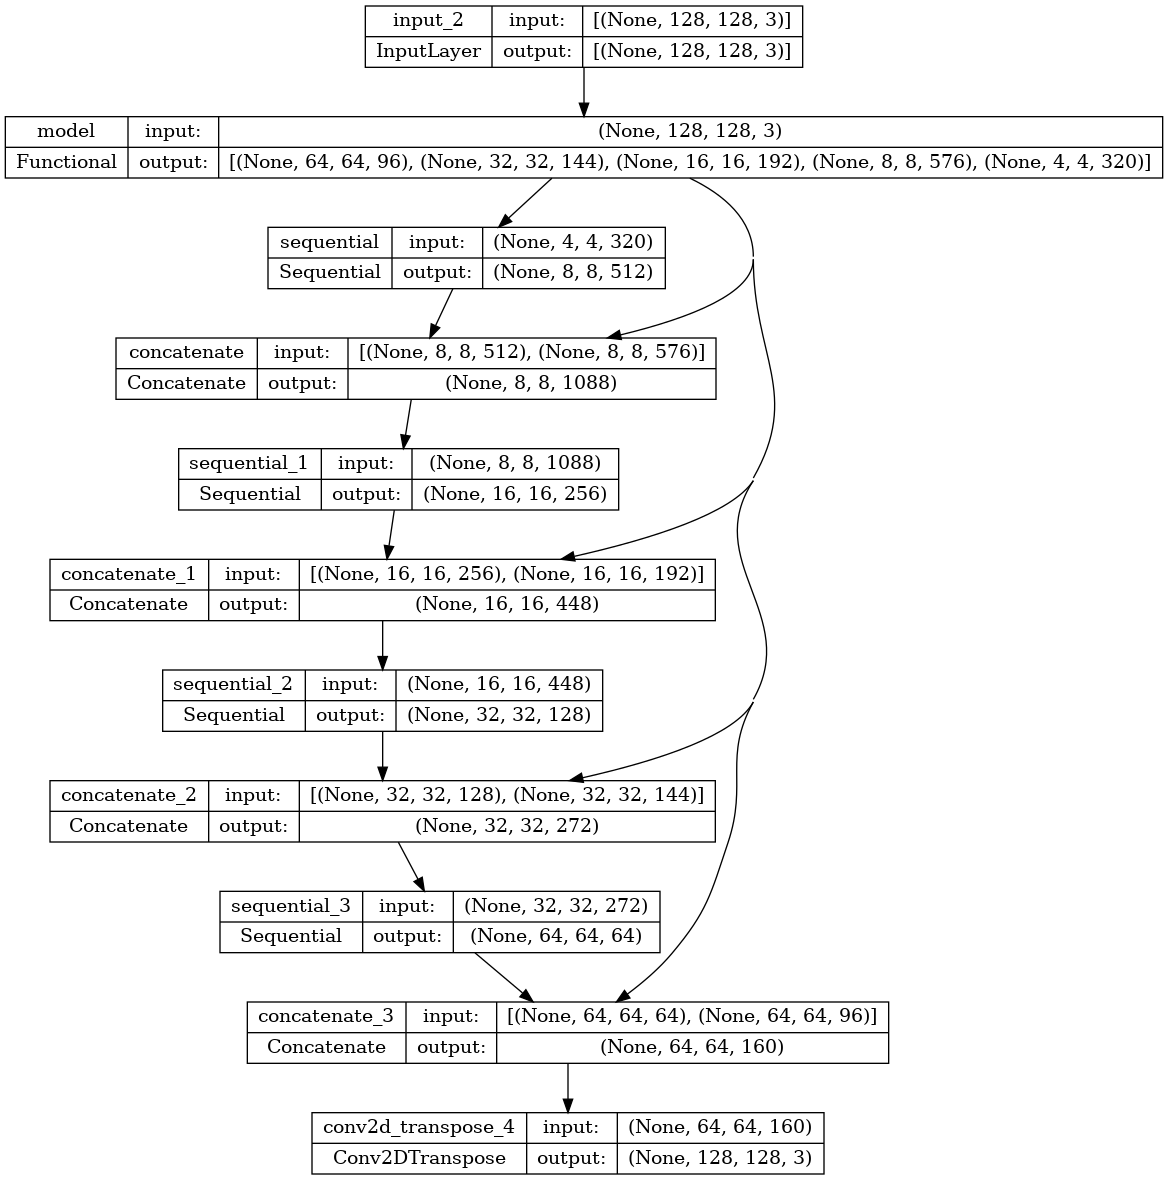

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True)

Try out the model to check what it predicts before training:

In [19]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [20]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])


1/1 [==============================] - ETA: 0s


1/1 [==============================] - 2s 2s/step


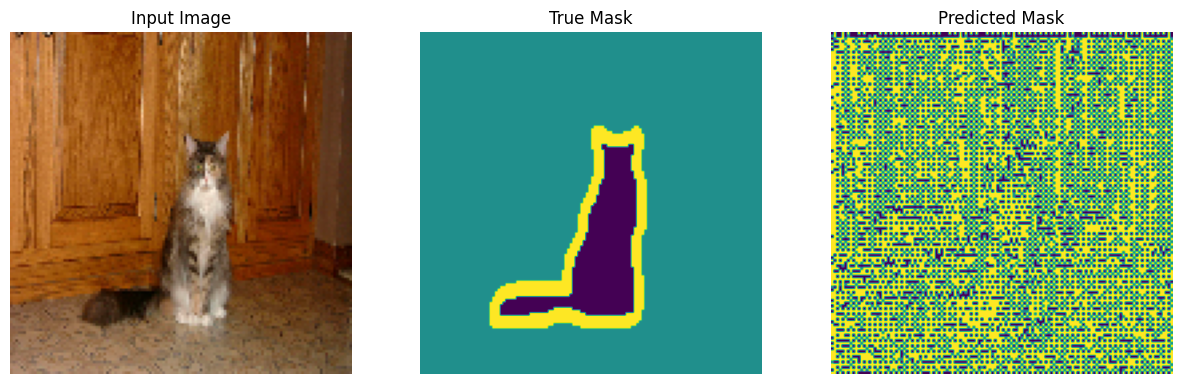

In [21]:
show_predictions()

The callback defined below is used to observe how the model improves while it is training:

In [22]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))


1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step


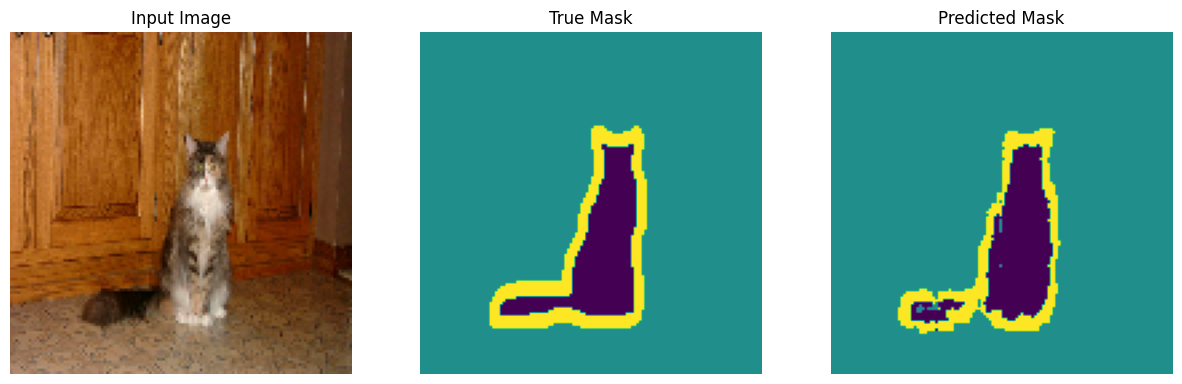


Sample Prediction after epoch 20


57/57 [==============================] - 5s 88ms/step - loss: 0.1722 - accuracy: 0.9297 - val_loss: 0.2715 - val_accuracy: 0.9052


In [23]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

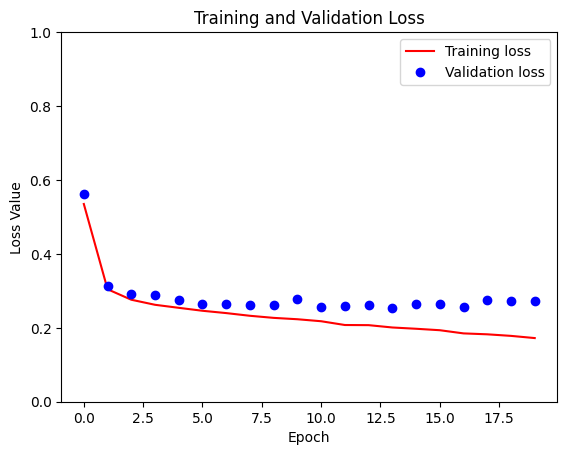

In [24]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Make predictions

Now, make some predictions. In the interest of saving time, the number of epochs was kept small, but you may set this higher to achieve more accurate results.


1/2 [==============>...............] - ETA: 0s


2/2 [==============================] - 0s 19ms/step


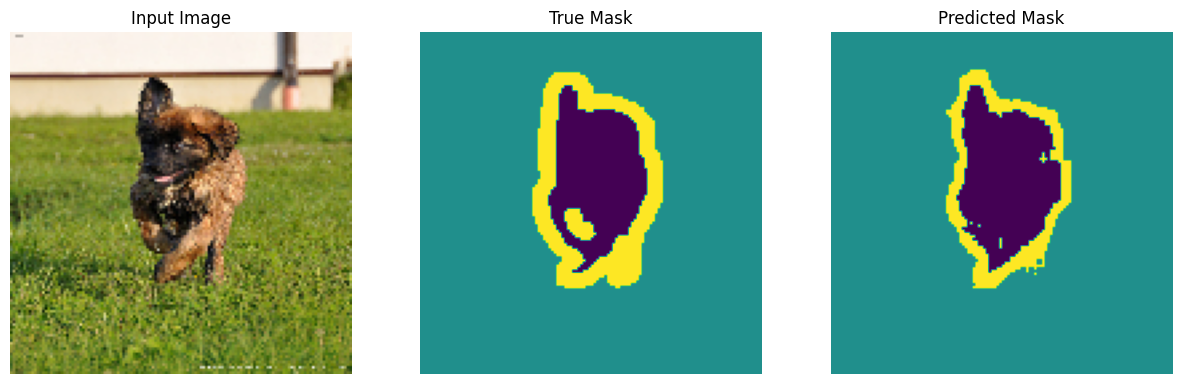


1/2 [==============>...............] - ETA: 0s


2/2 [==============================] - 0s 20ms/step


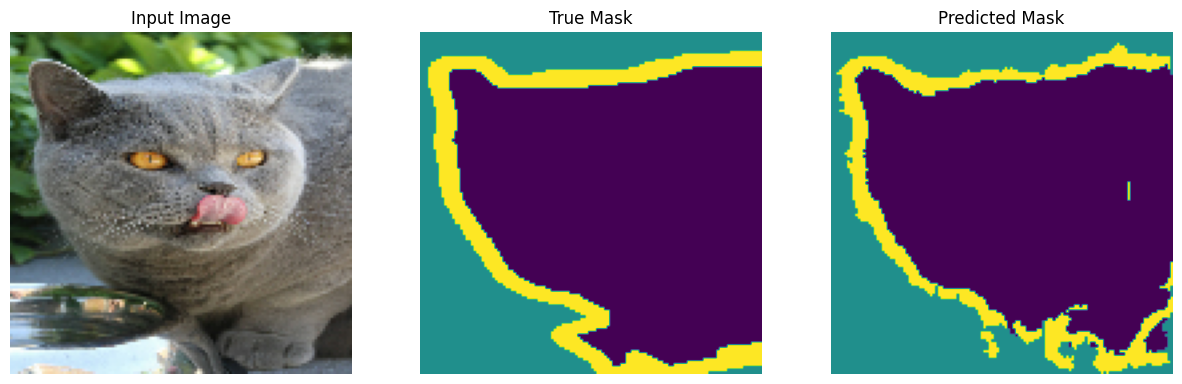


1/2 [==============>...............] - ETA: 0s


2/2 [==============================] - 0s 19ms/step


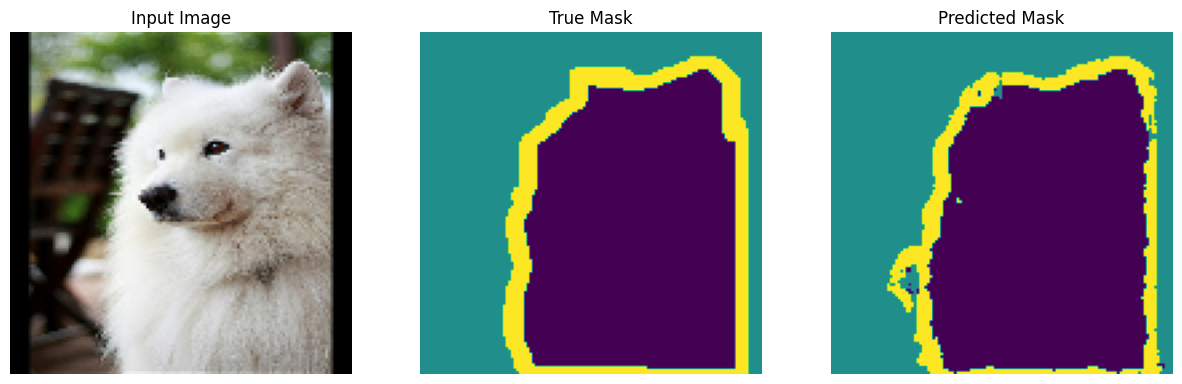

In [25]:
show_predictions(test_batches, 3)

## Optional: Imbalanced classes and class weights

Semantic segmentation datasets can be highly imbalanced meaning that particular class pixels can be present more inside images than that of other classes. Since segmentation problems can be treated as per-pixel classification problems, you can deal with the imbalance problem by weighing the loss function to account for this. It's a simple and elegant way to deal with this problem. Refer to the [Classification on imbalanced data](../structured_data/imbalanced_data.ipynb) tutorial to learn more.

To [avoid ambiguity](https://github.com/keras-team/keras/issues/3653#issuecomment-243939748), `Model.fit` does not support the `class_weight` argument for targets with 3+ dimensions.

In [26]:
try:
  model_history = model.fit(train_batches, epochs=EPOCHS,
                            steps_per_epoch=STEPS_PER_EPOCH,
                            class_weight = {0:2.0, 1:2.0, 2:1.0})
  assert False
except Exception as e:
  print(f"Expected {type(e).__name__}: {e}")

Epoch 1/20



 1/57 [..............................] - ETA: 1:26 - loss: 0.2424 - accuracy: 0.9329


 2/57 [>.............................] - ETA: 3s - loss: 0.2498 - accuracy: 0.9315  


 3/57 [>.............................] - ETA: 3s - loss: 0.2444 - accuracy: 0.9297


 4/57 [=>............................] - ETA: 3s - loss: 0.2452 - accuracy: 0.9271


 5/57 [=>............................] - ETA: 3s - loss: 0.2430 - accuracy: 0.9259


 6/57 [==>...........................] - ETA: 3s - loss: 0.2439 - accuracy: 0.9253


 7/57 [==>...........................] - ETA: 3s - loss: 0.2457 - accuracy: 0.9252


 8/57 [===>..........................] - ETA: 3s - loss: 0.2507 - accuracy: 0.9242


 9/57 [===>..........................] - ETA: 3s - loss: 0.2533 - accuracy: 0.9238


10/57 [====>.........................] - ETA: 3s - loss: 0.2529 - accuracy: 0.9242


11/57 [====>.........................] - ETA: 3s - loss: 0.2561 - accuracy: 0.9232


12/57 [=====>........................] - ETA: 3s - loss: 0.2579 - accuracy: 0.9225


13/57 [=====>........................] - ETA: 2s - loss: 0.2601 - accuracy: 0.9218


14/57 [======>.......................] - ETA: 2s - loss: 0.2590 - accuracy: 0.9221


15/57 [======>.......................] - ETA: 2s - loss: 0.2585 - accuracy: 0.9222


16/57 [=======>......................] - ETA: 2s - loss: 0.2589 - accuracy: 0.9224


17/57 [=======>......................] - ETA: 2s - loss: 0.2594 - accuracy: 0.9221


18/57 [========>.....................] - ETA: 2s - loss: 0.2601 - accuracy: 0.9217


19/57 [=========>....................] - ETA: 2s - loss: 0.2600 - accuracy: 0.9217


20/57 [=========>....................] - ETA: 2s - loss: 0.2607 - accuracy: 0.9216


21/57 [==========>...................] - ETA: 2s - loss: 0.2611 - accuracy: 0.9218


22/57 [==========>...................] - ETA: 2s - loss: 0.2602 - accuracy: 0.9218


23/57 [===========>..................] - ETA: 2s - loss: 0.2605 - accuracy: 0.9216


24/57 [===========>..................] - ETA: 2s - loss: 0.2612 - accuracy: 0.9214


25/57 [============>.................] - ETA: 2s - loss: 0.2617 - accuracy: 0.9214


26/57 [============>.................] - ETA: 2s - loss: 0.2624 - accuracy: 0.9212


27/57 [=============>................] - ETA: 2s - loss: 0.2630 - accuracy: 0.9211


28/57 [=============>................] - ETA: 1s - loss: 0.2650 - accuracy: 0.9207


29/57 [==============>...............] - ETA: 1s - loss: 0.2654 - accuracy: 0.9206


30/57 [==============>...............] - ETA: 1s - loss: 0.2650 - accuracy: 0.9206


31/57 [===============>..............] - ETA: 1s - loss: 0.2672 - accuracy: 0.9202


32/57 [===============>..............] - ETA: 1s - loss: 0.2681 - accuracy: 0.9201


33/57 [================>.............] - ETA: 1s - loss: 0.2688 - accuracy: 0.9200


34/57 [================>.............] - ETA: 1s - loss: 0.2684 - accuracy: 0.9201


35/57 [=================>............] - ETA: 1s - loss: 0.2686 - accuracy: 0.9201


36/57 [=================>............] - ETA: 1s - loss: 0.2691 - accuracy: 0.9199


37/57 [==================>...........] - ETA: 1s - loss: 0.2688 - accuracy: 0.9199


38/57 [===================>..........] - ETA: 1s - loss: 0.2685 - accuracy: 0.9199


39/57 [===================>..........] - ETA: 1s - loss: 0.2690 - accuracy: 0.9198


40/57 [====================>.........] - ETA: 1s - loss: 0.2689 - accuracy: 0.9198


41/57 [====================>.........] - ETA: 1s - loss: 0.2691 - accuracy: 0.9198


42/57 [=====================>........] - ETA: 1s - loss: 0.2697 - accuracy: 0.9198


43/57 [=====================>........] - ETA: 0s - loss: 0.2692 - accuracy: 0.9199


44/57 [======================>.......] - ETA: 0s - loss: 0.2693 - accuracy: 0.9200


45/57 [======================>.......] - ETA: 0s - loss: 0.2688 - accuracy: 0.9201


46/57 [=======================>......] - ETA: 0s - loss: 0.2691 - accuracy: 0.9200


47/57 [=======================>......] - ETA: 0s - loss: 0.2695 - accuracy: 0.9198


48/57 [========================>.....] - ETA: 0s - loss: 0.2694 - accuracy: 0.9198


49/57 [========================>.....] - ETA: 0s - loss: 0.2694 - accuracy: 0.9198


50/57 [=========================>....] - ETA: 0s - loss: 0.2698 - accuracy: 0.9197


51/57 [=========================>....] - ETA: 0s - loss: 0.2694 - accuracy: 0.9198


52/57 [==========================>...] - ETA: 0s - loss: 0.2696 - accuracy: 0.9198


53/57 [==========================>...] - ETA: 0s - loss: 0.2695 - accuracy: 0.9197


54/57 [===========================>..] - ETA: 0s - loss: 0.2694 - accuracy: 0.9197


55/57 [===========================>..] - ETA: 0s - loss: 0.2694 - accuracy: 0.9196


56/57 [============================>.] - ETA: 0s - loss: 0.2695 - accuracy: 0.9196


57/57 [==============================] - ETA: 0s - loss: 0.2694 - accuracy: 0.9197


57/57 [==============================] - 5s 67ms/step - loss: 0.2694 - accuracy: 0.9197


Epoch 2/20



 1/57 [..............................] - ETA: 2s - loss: 0.2948 - accuracy: 0.9132


 2/57 [>.............................] - ETA: 3s - loss: 0.2788 - accuracy: 0.9174


 3/57 [>.............................] - ETA: 3s - loss: 0.2677 - accuracy: 0.9189


 4/57 [=>............................] - ETA: 3s - loss: 0.2604 - accuracy: 0.9202


 5/57 [=>............................] - ETA: 3s - loss: 0.2593 - accuracy: 0.9207


 6/57 [==>...........................] - ETA: 3s - loss: 0.2573 - accuracy: 0.9212


 7/57 [==>...........................] - ETA: 3s - loss: 0.2595 - accuracy: 0.9203


 8/57 [===>..........................] - ETA: 3s - loss: 0.2576 - accuracy: 0.9209


 9/57 [===>..........................] - ETA: 3s - loss: 0.2564 - accuracy: 0.9218


10/57 [====>.........................] - ETA: 3s - loss: 0.2559 - accuracy: 0.9221


11/57 [====>.........................] - ETA: 3s - loss: 0.2548 - accuracy: 0.9224


12/57 [=====>........................] - ETA: 3s - loss: 0.2548 - accuracy: 0.9224


13/57 [=====>........................] - ETA: 2s - loss: 0.2542 - accuracy: 0.9226


14/57 [======>.......................] - ETA: 2s - loss: 0.2546 - accuracy: 0.9224


15/57 [======>.......................] - ETA: 2s - loss: 0.2555 - accuracy: 0.9222


16/57 [=======>......................] - ETA: 2s - loss: 0.2551 - accuracy: 0.9225


17/57 [=======>......................] - ETA: 2s - loss: 0.2555 - accuracy: 0.9225


18/57 [========>.....................] - ETA: 2s - loss: 0.2553 - accuracy: 0.9224


19/57 [=========>....................] - ETA: 2s - loss: 0.2556 - accuracy: 0.9222


20/57 [=========>....................] - ETA: 2s - loss: 0.2553 - accuracy: 0.9222


21/57 [==========>...................] - ETA: 2s - loss: 0.2552 - accuracy: 0.9221


22/57 [==========>...................] - ETA: 2s - loss: 0.2549 - accuracy: 0.9222


23/57 [===========>..................] - ETA: 2s - loss: 0.2552 - accuracy: 0.9223


24/57 [===========>..................] - ETA: 2s - loss: 0.2558 - accuracy: 0.9221


25/57 [============>.................] - ETA: 2s - loss: 0.2558 - accuracy: 0.9221


26/57 [============>.................] - ETA: 2s - loss: 0.2553 - accuracy: 0.9222


27/57 [=============>................] - ETA: 2s - loss: 0.2551 - accuracy: 0.9225


28/57 [=============>................] - ETA: 1s - loss: 0.2547 - accuracy: 0.9226


29/57 [==============>...............] - ETA: 1s - loss: 0.2533 - accuracy: 0.9228


30/57 [==============>...............] - ETA: 1s - loss: 0.2528 - accuracy: 0.9228


31/57 [===============>..............] - ETA: 1s - loss: 0.2533 - accuracy: 0.9227


32/57 [===============>..............] - ETA: 1s - loss: 0.2526 - accuracy: 0.9228


33/57 [================>.............] - ETA: 1s - loss: 0.2527 - accuracy: 0.9229


34/57 [================>.............] - ETA: 1s - loss: 0.2520 - accuracy: 0.9231


35/57 [=================>............] - ETA: 1s - loss: 0.2522 - accuracy: 0.9232


36/57 [=================>............] - ETA: 1s - loss: 0.2521 - accuracy: 0.9232


37/57 [==================>...........] - ETA: 1s - loss: 0.2519 - accuracy: 0.9233


38/57 [===================>..........] - ETA: 1s - loss: 0.2523 - accuracy: 0.9231


39/57 [===================>..........] - ETA: 1s - loss: 0.2521 - accuracy: 0.9231


40/57 [====================>.........] - ETA: 1s - loss: 0.2521 - accuracy: 0.9231


41/57 [====================>.........] - ETA: 1s - loss: 0.2527 - accuracy: 0.9230


42/57 [=====================>........] - ETA: 1s - loss: 0.2529 - accuracy: 0.9230


43/57 [=====================>........] - ETA: 0s - loss: 0.2532 - accuracy: 0.9230


44/57 [======================>.......] - ETA: 0s - loss: 0.2536 - accuracy: 0.9229


45/57 [======================>.......] - ETA: 0s - loss: 0.2537 - accuracy: 0.9229


46/57 [=======================>......] - ETA: 0s - loss: 0.2542 - accuracy: 0.9227


47/57 [=======================>......] - ETA: 0s - loss: 0.2542 - accuracy: 0.9228


48/57 [========================>.....] - ETA: 0s - loss: 0.2541 - accuracy: 0.9228


49/57 [========================>.....] - ETA: 0s - loss: 0.2547 - accuracy: 0.9226


50/57 [=========================>....] - ETA: 0s - loss: 0.2545 - accuracy: 0.9227


51/57 [=========================>....] - ETA: 0s - loss: 0.2541 - accuracy: 0.9228


52/57 [==========================>...] - ETA: 0s - loss: 0.2545 - accuracy: 0.9227


53/57 [==========================>...] - ETA: 0s - loss: 0.2547 - accuracy: 0.9227


54/57 [===========================>..] - ETA: 0s - loss: 0.2540 - accuracy: 0.9229


55/57 [===========================>..] - ETA: 0s - loss: 0.2539 - accuracy: 0.9229


56/57 [============================>.] - ETA: 0s - loss: 0.2536 - accuracy: 0.9230


57/57 [==============================] - ETA: 0s - loss: 0.2534 - accuracy: 0.9229


57/57 [==============================] - 4s 67ms/step - loss: 0.2534 - accuracy: 0.9229


Epoch 3/20



 1/57 [..............................] - ETA: 3s - loss: 0.2469 - accuracy: 0.9211


 3/57 [>.............................] - ETA: 2s - loss: 0.2504 - accuracy: 0.9237


 4/57 [=>............................] - ETA: 3s - loss: 0.2462 - accuracy: 0.9252


 5/57 [=>............................] - ETA: 3s - loss: 0.2524 - accuracy: 0.9240


 6/57 [==>...........................] - ETA: 3s - loss: 0.2581 - accuracy: 0.9220


 7/57 [==>...........................] - ETA: 3s - loss: 0.2594 - accuracy: 0.9213


 8/57 [===>..........................] - ETA: 3s - loss: 0.2565 - accuracy: 0.9217


 9/57 [===>..........................] - ETA: 3s - loss: 0.2574 - accuracy: 0.9217


10/57 [====>.........................] - ETA: 3s - loss: 0.2532 - accuracy: 0.9228


11/57 [====>.........................] - ETA: 2s - loss: 0.2510 - accuracy: 0.9236


12/57 [=====>........................] - ETA: 2s - loss: 0.2519 - accuracy: 0.9235


13/57 [=====>........................] - ETA: 2s - loss: 0.2510 - accuracy: 0.9237


14/57 [======>.......................] - ETA: 2s - loss: 0.2527 - accuracy: 0.9231


15/57 [======>.......................] - ETA: 2s - loss: 0.2546 - accuracy: 0.9228


16/57 [=======>......................] - ETA: 2s - loss: 0.2542 - accuracy: 0.9227


17/57 [=======>......................] - ETA: 2s - loss: 0.2549 - accuracy: 0.9224


18/57 [========>.....................] - ETA: 2s - loss: 0.2548 - accuracy: 0.9227


19/57 [=========>....................] - ETA: 2s - loss: 0.2546 - accuracy: 0.9225


20/57 [=========>....................] - ETA: 2s - loss: 0.2541 - accuracy: 0.9225


21/57 [==========>...................] - ETA: 2s - loss: 0.2527 - accuracy: 0.9229


22/57 [==========>...................] - ETA: 2s - loss: 0.2523 - accuracy: 0.9230


23/57 [===========>..................] - ETA: 2s - loss: 0.2514 - accuracy: 0.9233


24/57 [===========>..................] - ETA: 2s - loss: 0.2507 - accuracy: 0.9236


25/57 [============>.................] - ETA: 2s - loss: 0.2506 - accuracy: 0.9237


26/57 [============>.................] - ETA: 2s - loss: 0.2501 - accuracy: 0.9238


27/57 [=============>................] - ETA: 1s - loss: 0.2502 - accuracy: 0.9238


28/57 [=============>................] - ETA: 1s - loss: 0.2495 - accuracy: 0.9238


29/57 [==============>...............] - ETA: 1s - loss: 0.2492 - accuracy: 0.9239


30/57 [==============>...............] - ETA: 1s - loss: 0.2491 - accuracy: 0.9239


31/57 [===============>..............] - ETA: 1s - loss: 0.2497 - accuracy: 0.9238


32/57 [===============>..............] - ETA: 1s - loss: 0.2495 - accuracy: 0.9240


33/57 [================>.............] - ETA: 1s - loss: 0.2493 - accuracy: 0.9240


34/57 [================>.............] - ETA: 1s - loss: 0.2487 - accuracy: 0.9242


35/57 [=================>............] - ETA: 1s - loss: 0.2480 - accuracy: 0.9243


36/57 [=================>............] - ETA: 1s - loss: 0.2477 - accuracy: 0.9243


37/57 [==================>...........] - ETA: 1s - loss: 0.2472 - accuracy: 0.9244


38/57 [===================>..........] - ETA: 1s - loss: 0.2465 - accuracy: 0.9246


39/57 [===================>..........] - ETA: 1s - loss: 0.2464 - accuracy: 0.9247


40/57 [====================>.........] - ETA: 1s - loss: 0.2467 - accuracy: 0.9247


41/57 [====================>.........] - ETA: 1s - loss: 0.2468 - accuracy: 0.9246


42/57 [=====================>........] - ETA: 0s - loss: 0.2470 - accuracy: 0.9246


43/57 [=====================>........] - ETA: 0s - loss: 0.2470 - accuracy: 0.9246


44/57 [======================>.......] - ETA: 0s - loss: 0.2471 - accuracy: 0.9246


45/57 [======================>.......] - ETA: 0s - loss: 0.2470 - accuracy: 0.9247


46/57 [=======================>......] - ETA: 0s - loss: 0.2467 - accuracy: 0.9247


47/57 [=======================>......] - ETA: 0s - loss: 0.2461 - accuracy: 0.9248


48/57 [========================>.....] - ETA: 0s - loss: 0.2460 - accuracy: 0.9247


49/57 [========================>.....] - ETA: 0s - loss: 0.2461 - accuracy: 0.9247


50/57 [=========================>....] - ETA: 0s - loss: 0.2462 - accuracy: 0.9246


51/57 [=========================>....] - ETA: 0s - loss: 0.2463 - accuracy: 0.9247


52/57 [==========================>...] - ETA: 0s - loss: 0.2458 - accuracy: 0.9248


53/57 [==========================>...] - ETA: 0s - loss: 0.2458 - accuracy: 0.9248


54/57 [===========================>..] - ETA: 0s - loss: 0.2460 - accuracy: 0.9247


55/57 [===========================>..] - ETA: 0s - loss: 0.2456 - accuracy: 0.9248


56/57 [============================>.] - ETA: 0s - loss: 0.2455 - accuracy: 0.9248


57/57 [==============================] - ETA: 0s - loss: 0.2456 - accuracy: 0.9248


57/57 [==============================] - 4s 66ms/step - loss: 0.2456 - accuracy: 0.9248


Epoch 4/20



 1/57 [..............................] - ETA: 3s - loss: 0.2325 - accuracy: 0.9282


 2/57 [>.............................] - ETA: 3s - loss: 0.2512 - accuracy: 0.9231


 4/57 [=>............................] - ETA: 2s - loss: 0.2459 - accuracy: 0.9244


 5/57 [=>............................] - ETA: 3s - loss: 0.2434 - accuracy: 0.9244


 6/57 [==>...........................] - ETA: 3s - loss: 0.2405 - accuracy: 0.9251


 7/57 [==>...........................] - ETA: 3s - loss: 0.2382 - accuracy: 0.9259


 8/57 [===>..........................] - ETA: 3s - loss: 0.2377 - accuracy: 0.9262


 9/57 [===>..........................] - ETA: 3s - loss: 0.2365 - accuracy: 0.9267


10/57 [====>.........................] - ETA: 2s - loss: 0.2370 - accuracy: 0.9266


11/57 [====>.........................] - ETA: 2s - loss: 0.2361 - accuracy: 0.9271


12/57 [=====>........................] - ETA: 2s - loss: 0.2354 - accuracy: 0.9276


13/57 [=====>........................] - ETA: 2s - loss: 0.2355 - accuracy: 0.9274


14/57 [======>.......................] - ETA: 2s - loss: 0.2348 - accuracy: 0.9276


15/57 [======>.......................] - ETA: 2s - loss: 0.2350 - accuracy: 0.9274


16/57 [=======>......................] - ETA: 2s - loss: 0.2350 - accuracy: 0.9275


17/57 [=======>......................] - ETA: 2s - loss: 0.2349 - accuracy: 0.9277


18/57 [========>.....................] - ETA: 2s - loss: 0.2355 - accuracy: 0.9275


19/57 [=========>....................] - ETA: 2s - loss: 0.2342 - accuracy: 0.9281


20/57 [=========>....................] - ETA: 2s - loss: 0.2344 - accuracy: 0.9279


21/57 [==========>...................] - ETA: 2s - loss: 0.2355 - accuracy: 0.9277


22/57 [==========>...................] - ETA: 2s - loss: 0.2361 - accuracy: 0.9273


23/57 [===========>..................] - ETA: 2s - loss: 0.2358 - accuracy: 0.9274


24/57 [===========>..................] - ETA: 2s - loss: 0.2350 - accuracy: 0.9276


25/57 [============>.................] - ETA: 2s - loss: 0.2339 - accuracy: 0.9279


26/57 [============>.................] - ETA: 2s - loss: 0.2346 - accuracy: 0.9276


27/57 [=============>................] - ETA: 1s - loss: 0.2348 - accuracy: 0.9275


28/57 [=============>................] - ETA: 1s - loss: 0.2339 - accuracy: 0.9278


29/57 [==============>...............] - ETA: 1s - loss: 0.2340 - accuracy: 0.9278


30/57 [==============>...............] - ETA: 1s - loss: 0.2334 - accuracy: 0.9281


31/57 [===============>..............] - ETA: 1s - loss: 0.2341 - accuracy: 0.9278


32/57 [===============>..............] - ETA: 1s - loss: 0.2342 - accuracy: 0.9278


33/57 [================>.............] - ETA: 1s - loss: 0.2344 - accuracy: 0.9277


34/57 [================>.............] - ETA: 1s - loss: 0.2347 - accuracy: 0.9276


35/57 [=================>............] - ETA: 1s - loss: 0.2346 - accuracy: 0.9277


36/57 [=================>............] - ETA: 1s - loss: 0.2346 - accuracy: 0.9278


37/57 [==================>...........] - ETA: 1s - loss: 0.2343 - accuracy: 0.9278


38/57 [===================>..........] - ETA: 1s - loss: 0.2348 - accuracy: 0.9276


39/57 [===================>..........] - ETA: 1s - loss: 0.2339 - accuracy: 0.9279


40/57 [====================>.........] - ETA: 1s - loss: 0.2337 - accuracy: 0.9279


41/57 [====================>.........] - ETA: 1s - loss: 0.2336 - accuracy: 0.9279


42/57 [=====================>........] - ETA: 0s - loss: 0.2343 - accuracy: 0.9276


43/57 [=====================>........] - ETA: 0s - loss: 0.2341 - accuracy: 0.9277


44/57 [======================>.......] - ETA: 0s - loss: 0.2335 - accuracy: 0.9279


45/57 [======================>.......] - ETA: 0s - loss: 0.2337 - accuracy: 0.9279


46/57 [=======================>......] - ETA: 0s - loss: 0.2336 - accuracy: 0.9280


47/57 [=======================>......] - ETA: 0s - loss: 0.2338 - accuracy: 0.9278


48/57 [========================>.....] - ETA: 0s - loss: 0.2339 - accuracy: 0.9277


49/57 [========================>.....] - ETA: 0s - loss: 0.2341 - accuracy: 0.9276


50/57 [=========================>....] - ETA: 0s - loss: 0.2343 - accuracy: 0.9275


51/57 [=========================>....] - ETA: 0s - loss: 0.2341 - accuracy: 0.9276


52/57 [==========================>...] - ETA: 0s - loss: 0.2341 - accuracy: 0.9277


53/57 [==========================>...] - ETA: 0s - loss: 0.2344 - accuracy: 0.9277


54/57 [===========================>..] - ETA: 0s - loss: 0.2343 - accuracy: 0.9277


55/57 [===========================>..] - ETA: 0s - loss: 0.2343 - accuracy: 0.9277


56/57 [============================>.] - ETA: 0s - loss: 0.2344 - accuracy: 0.9277


57/57 [==============================] - ETA: 0s - loss: 0.2347 - accuracy: 0.9276


57/57 [==============================] - 4s 66ms/step - loss: 0.2347 - accuracy: 0.9276


Epoch 5/20



 1/57 [..............................] - ETA: 3s - loss: 0.2276 - accuracy: 0.9289


 2/57 [>.............................] - ETA: 3s - loss: 0.2348 - accuracy: 0.9270


 3/57 [>.............................] - ETA: 3s - loss: 0.2298 - accuracy: 0.9281


 5/57 [=>............................] - ETA: 3s - loss: 0.2290 - accuracy: 0.9288


 6/57 [==>...........................] - ETA: 3s - loss: 0.2298 - accuracy: 0.9287


 7/57 [==>...........................] - ETA: 3s - loss: 0.2316 - accuracy: 0.9291


 8/57 [===>..........................] - ETA: 3s - loss: 0.2341 - accuracy: 0.9282


 9/57 [===>..........................] - ETA: 3s - loss: 0.2321 - accuracy: 0.9284


10/57 [====>.........................] - ETA: 2s - loss: 0.2322 - accuracy: 0.9281


11/57 [====>.........................] - ETA: 2s - loss: 0.2334 - accuracy: 0.9276


12/57 [=====>........................] - ETA: 2s - loss: 0.2326 - accuracy: 0.9277


13/57 [=====>........................] - ETA: 2s - loss: 0.2322 - accuracy: 0.9277


14/57 [======>.......................] - ETA: 2s - loss: 0.2311 - accuracy: 0.9284


15/57 [======>.......................] - ETA: 2s - loss: 0.2307 - accuracy: 0.9287


16/57 [=======>......................] - ETA: 2s - loss: 0.2295 - accuracy: 0.9290


17/57 [=======>......................] - ETA: 2s - loss: 0.2297 - accuracy: 0.9289


18/57 [========>.....................] - ETA: 2s - loss: 0.2297 - accuracy: 0.9288


19/57 [=========>....................] - ETA: 2s - loss: 0.2299 - accuracy: 0.9286


20/57 [=========>....................] - ETA: 2s - loss: 0.2290 - accuracy: 0.9288


21/57 [==========>...................] - ETA: 2s - loss: 0.2291 - accuracy: 0.9288


22/57 [==========>...................] - ETA: 2s - loss: 0.2290 - accuracy: 0.9289


23/57 [===========>..................] - ETA: 2s - loss: 0.2287 - accuracy: 0.9292


24/57 [===========>..................] - ETA: 2s - loss: 0.2278 - accuracy: 0.9296


25/57 [============>.................] - ETA: 2s - loss: 0.2280 - accuracy: 0.9294


26/57 [============>.................] - ETA: 2s - loss: 0.2287 - accuracy: 0.9292


27/57 [=============>................] - ETA: 1s - loss: 0.2290 - accuracy: 0.9291


28/57 [=============>................] - ETA: 1s - loss: 0.2285 - accuracy: 0.9292


29/57 [==============>...............] - ETA: 1s - loss: 0.2283 - accuracy: 0.9291


30/57 [==============>...............] - ETA: 1s - loss: 0.2282 - accuracy: 0.9292


31/57 [===============>..............] - ETA: 1s - loss: 0.2281 - accuracy: 0.9292


32/57 [===============>..............] - ETA: 1s - loss: 0.2279 - accuracy: 0.9294


33/57 [================>.............] - ETA: 1s - loss: 0.2277 - accuracy: 0.9294


34/57 [================>.............] - ETA: 1s - loss: 0.2277 - accuracy: 0.9294


35/57 [=================>............] - ETA: 1s - loss: 0.2275 - accuracy: 0.9294


36/57 [=================>............] - ETA: 1s - loss: 0.2274 - accuracy: 0.9294


37/57 [==================>...........] - ETA: 1s - loss: 0.2272 - accuracy: 0.9296


38/57 [===================>..........] - ETA: 1s - loss: 0.2271 - accuracy: 0.9296


39/57 [===================>..........] - ETA: 1s - loss: 0.2267 - accuracy: 0.9297


40/57 [====================>.........] - ETA: 1s - loss: 0.2263 - accuracy: 0.9298


41/57 [====================>.........] - ETA: 1s - loss: 0.2257 - accuracy: 0.9300


42/57 [=====================>........] - ETA: 0s - loss: 0.2258 - accuracy: 0.9299


43/57 [=====================>........] - ETA: 0s - loss: 0.2261 - accuracy: 0.9298


44/57 [======================>.......] - ETA: 0s - loss: 0.2263 - accuracy: 0.9298


45/57 [======================>.......] - ETA: 0s - loss: 0.2263 - accuracy: 0.9299


46/57 [=======================>......] - ETA: 0s - loss: 0.2263 - accuracy: 0.9299


47/57 [=======================>......] - ETA: 0s - loss: 0.2263 - accuracy: 0.9299


48/57 [========================>.....] - ETA: 0s - loss: 0.2260 - accuracy: 0.9300


49/57 [========================>.....] - ETA: 0s - loss: 0.2260 - accuracy: 0.9300


50/57 [=========================>....] - ETA: 0s - loss: 0.2262 - accuracy: 0.9299


51/57 [=========================>....] - ETA: 0s - loss: 0.2262 - accuracy: 0.9299


52/57 [==========================>...] - ETA: 0s - loss: 0.2267 - accuracy: 0.9297


53/57 [==========================>...] - ETA: 0s - loss: 0.2267 - accuracy: 0.9297


54/57 [===========================>..] - ETA: 0s - loss: 0.2266 - accuracy: 0.9297


55/57 [===========================>..] - ETA: 0s - loss: 0.2266 - accuracy: 0.9297


56/57 [============================>.] - ETA: 0s - loss: 0.2266 - accuracy: 0.9298


57/57 [==============================] - ETA: 0s - loss: 0.2266 - accuracy: 0.9297


57/57 [==============================] - 4s 66ms/step - loss: 0.2266 - accuracy: 0.9297


Epoch 6/20



 1/57 [..............................] - ETA: 3s - loss: 0.2280 - accuracy: 0.9310


 2/57 [>.............................] - ETA: 3s - loss: 0.2183 - accuracy: 0.9327


 3/57 [>.............................] - ETA: 3s - loss: 0.2242 - accuracy: 0.9307


 4/57 [=>............................] - ETA: 3s - loss: 0.2249 - accuracy: 0.9305


 6/57 [==>...........................] - ETA: 3s - loss: 0.2232 - accuracy: 0.9306


 7/57 [==>...........................] - ETA: 3s - loss: 0.2243 - accuracy: 0.9303


 8/57 [===>..........................] - ETA: 3s - loss: 0.2227 - accuracy: 0.9305


 9/57 [===>..........................] - ETA: 3s - loss: 0.2203 - accuracy: 0.9313


10/57 [====>.........................] - ETA: 2s - loss: 0.2204 - accuracy: 0.9308


11/57 [====>.........................] - ETA: 2s - loss: 0.2217 - accuracy: 0.9305


12/57 [=====>........................] - ETA: 2s - loss: 0.2199 - accuracy: 0.9314


13/57 [=====>........................] - ETA: 2s - loss: 0.2190 - accuracy: 0.9316


14/57 [======>.......................] - ETA: 2s - loss: 0.2170 - accuracy: 0.9322


15/57 [======>.......................] - ETA: 2s - loss: 0.2163 - accuracy: 0.9322


16/57 [=======>......................] - ETA: 2s - loss: 0.2164 - accuracy: 0.9321


17/57 [=======>......................] - ETA: 2s - loss: 0.2176 - accuracy: 0.9320


18/57 [========>.....................] - ETA: 2s - loss: 0.2177 - accuracy: 0.9321


19/57 [=========>....................] - ETA: 2s - loss: 0.2186 - accuracy: 0.9318


20/57 [=========>....................] - ETA: 2s - loss: 0.2182 - accuracy: 0.9320


21/57 [==========>...................] - ETA: 2s - loss: 0.2178 - accuracy: 0.9322


22/57 [==========>...................] - ETA: 2s - loss: 0.2177 - accuracy: 0.9321


23/57 [===========>..................] - ETA: 2s - loss: 0.2176 - accuracy: 0.9321


24/57 [===========>..................] - ETA: 2s - loss: 0.2178 - accuracy: 0.9321


25/57 [============>.................] - ETA: 2s - loss: 0.2174 - accuracy: 0.9321


26/57 [============>.................] - ETA: 2s - loss: 0.2175 - accuracy: 0.9320


27/57 [=============>................] - ETA: 1s - loss: 0.2171 - accuracy: 0.9322


28/57 [=============>................] - ETA: 1s - loss: 0.2172 - accuracy: 0.9323


29/57 [==============>...............] - ETA: 1s - loss: 0.2178 - accuracy: 0.9321


30/57 [==============>...............] - ETA: 1s - loss: 0.2185 - accuracy: 0.9319


31/57 [===============>..............] - ETA: 1s - loss: 0.2185 - accuracy: 0.9318


32/57 [===============>..............] - ETA: 1s - loss: 0.2178 - accuracy: 0.9320


33/57 [================>.............] - ETA: 1s - loss: 0.2175 - accuracy: 0.9320


34/57 [================>.............] - ETA: 1s - loss: 0.2172 - accuracy: 0.9321


35/57 [=================>............] - ETA: 1s - loss: 0.2174 - accuracy: 0.9321


36/57 [=================>............] - ETA: 1s - loss: 0.2173 - accuracy: 0.9321


37/57 [==================>...........] - ETA: 1s - loss: 0.2173 - accuracy: 0.9321


38/57 [===================>..........] - ETA: 1s - loss: 0.2173 - accuracy: 0.9320


39/57 [===================>..........] - ETA: 1s - loss: 0.2172 - accuracy: 0.9321


40/57 [====================>.........] - ETA: 1s - loss: 0.2175 - accuracy: 0.9321


41/57 [====================>.........] - ETA: 1s - loss: 0.2175 - accuracy: 0.9322


42/57 [=====================>........] - ETA: 0s - loss: 0.2174 - accuracy: 0.9322


43/57 [=====================>........] - ETA: 0s - loss: 0.2178 - accuracy: 0.9321


44/57 [======================>.......] - ETA: 0s - loss: 0.2181 - accuracy: 0.9320


45/57 [======================>.......] - ETA: 0s - loss: 0.2182 - accuracy: 0.9320


46/57 [=======================>......] - ETA: 0s - loss: 0.2181 - accuracy: 0.9320


47/57 [=======================>......] - ETA: 0s - loss: 0.2178 - accuracy: 0.9322


48/57 [========================>.....] - ETA: 0s - loss: 0.2177 - accuracy: 0.9322


49/57 [========================>.....] - ETA: 0s - loss: 0.2176 - accuracy: 0.9322


50/57 [=========================>....] - ETA: 0s - loss: 0.2177 - accuracy: 0.9321


51/57 [=========================>....] - ETA: 0s - loss: 0.2180 - accuracy: 0.9320


52/57 [==========================>...] - ETA: 0s - loss: 0.2182 - accuracy: 0.9319


53/57 [==========================>...] - ETA: 0s - loss: 0.2181 - accuracy: 0.9320


54/57 [===========================>..] - ETA: 0s - loss: 0.2183 - accuracy: 0.9320


55/57 [===========================>..] - ETA: 0s - loss: 0.2186 - accuracy: 0.9319


56/57 [============================>.] - ETA: 0s - loss: 0.2186 - accuracy: 0.9318


57/57 [==============================] - ETA: 0s - loss: 0.2183 - accuracy: 0.9319


57/57 [==============================] - 4s 67ms/step - loss: 0.2183 - accuracy: 0.9319


Epoch 7/20



 1/57 [..............................] - ETA: 3s - loss: 0.2021 - accuracy: 0.9379


 2/57 [>.............................] - ETA: 3s - loss: 0.2052 - accuracy: 0.9361


 3/57 [>.............................] - ETA: 3s - loss: 0.2113 - accuracy: 0.9346


 4/57 [=>............................] - ETA: 3s - loss: 0.2185 - accuracy: 0.9327


 5/57 [=>............................] - ETA: 3s - loss: 0.2197 - accuracy: 0.9314


 7/57 [==>...........................] - ETA: 3s - loss: 0.2204 - accuracy: 0.9306


 8/57 [===>..........................] - ETA: 3s - loss: 0.2202 - accuracy: 0.9311


 9/57 [===>..........................] - ETA: 3s - loss: 0.2199 - accuracy: 0.9314


10/57 [====>.........................] - ETA: 2s - loss: 0.2205 - accuracy: 0.9314


11/57 [====>.........................] - ETA: 2s - loss: 0.2208 - accuracy: 0.9315


12/57 [=====>........................] - ETA: 2s - loss: 0.2207 - accuracy: 0.9315


13/57 [=====>........................] - ETA: 2s - loss: 0.2186 - accuracy: 0.9320


14/57 [======>.......................] - ETA: 2s - loss: 0.2182 - accuracy: 0.9318


15/57 [======>.......................] - ETA: 2s - loss: 0.2179 - accuracy: 0.9320


16/57 [=======>......................] - ETA: 2s - loss: 0.2170 - accuracy: 0.9322


17/57 [=======>......................] - ETA: 2s - loss: 0.2167 - accuracy: 0.9323


18/57 [========>.....................] - ETA: 2s - loss: 0.2156 - accuracy: 0.9327


19/57 [=========>....................] - ETA: 2s - loss: 0.2169 - accuracy: 0.9324


20/57 [=========>....................] - ETA: 2s - loss: 0.2160 - accuracy: 0.9327


21/57 [==========>...................] - ETA: 2s - loss: 0.2156 - accuracy: 0.9328


22/57 [==========>...................] - ETA: 2s - loss: 0.2151 - accuracy: 0.9329


23/57 [===========>..................] - ETA: 2s - loss: 0.2146 - accuracy: 0.9329


24/57 [===========>..................] - ETA: 2s - loss: 0.2159 - accuracy: 0.9324


25/57 [============>.................] - ETA: 2s - loss: 0.2155 - accuracy: 0.9326


26/57 [============>.................] - ETA: 2s - loss: 0.2152 - accuracy: 0.9327


27/57 [=============>................] - ETA: 1s - loss: 0.2152 - accuracy: 0.9328


28/57 [=============>................] - ETA: 1s - loss: 0.2153 - accuracy: 0.9329


29/57 [==============>...............] - ETA: 1s - loss: 0.2150 - accuracy: 0.9330


30/57 [==============>...............] - ETA: 1s - loss: 0.2152 - accuracy: 0.9328


31/57 [===============>..............] - ETA: 1s - loss: 0.2151 - accuracy: 0.9328


32/57 [===============>..............] - ETA: 1s - loss: 0.2147 - accuracy: 0.9328


33/57 [================>.............] - ETA: 1s - loss: 0.2145 - accuracy: 0.9329


34/57 [================>.............] - ETA: 1s - loss: 0.2142 - accuracy: 0.9329


35/57 [=================>............] - ETA: 1s - loss: 0.2141 - accuracy: 0.9329


36/57 [=================>............] - ETA: 1s - loss: 0.2141 - accuracy: 0.9330


37/57 [==================>...........] - ETA: 1s - loss: 0.2137 - accuracy: 0.9331


38/57 [===================>..........] - ETA: 1s - loss: 0.2136 - accuracy: 0.9331


39/57 [===================>..........] - ETA: 1s - loss: 0.2132 - accuracy: 0.9332


40/57 [====================>.........] - ETA: 1s - loss: 0.2135 - accuracy: 0.9330


41/57 [====================>.........] - ETA: 1s - loss: 0.2132 - accuracy: 0.9331


42/57 [=====================>........] - ETA: 0s - loss: 0.2131 - accuracy: 0.9332


43/57 [=====================>........] - ETA: 0s - loss: 0.2129 - accuracy: 0.9332


44/57 [======================>.......] - ETA: 0s - loss: 0.2130 - accuracy: 0.9332


45/57 [======================>.......] - ETA: 0s - loss: 0.2128 - accuracy: 0.9333


46/57 [=======================>......] - ETA: 0s - loss: 0.2130 - accuracy: 0.9332


47/57 [=======================>......] - ETA: 0s - loss: 0.2132 - accuracy: 0.9332


48/57 [========================>.....] - ETA: 0s - loss: 0.2136 - accuracy: 0.9330


49/57 [========================>.....] - ETA: 0s - loss: 0.2137 - accuracy: 0.9330


50/57 [=========================>....] - ETA: 0s - loss: 0.2136 - accuracy: 0.9330


51/57 [=========================>....] - ETA: 0s - loss: 0.2139 - accuracy: 0.9329


52/57 [==========================>...] - ETA: 0s - loss: 0.2144 - accuracy: 0.9329


53/57 [==========================>...] - ETA: 0s - loss: 0.2144 - accuracy: 0.9329


54/57 [===========================>..] - ETA: 0s - loss: 0.2142 - accuracy: 0.9330


55/57 [===========================>..] - ETA: 0s - loss: 0.2143 - accuracy: 0.9329


56/57 [============================>.] - ETA: 0s - loss: 0.2146 - accuracy: 0.9328


57/57 [==============================] - ETA: 0s - loss: 0.2151 - accuracy: 0.9326


57/57 [==============================] - 4s 66ms/step - loss: 0.2151 - accuracy: 0.9326


Epoch 8/20



 1/57 [..............................] - ETA: 3s - loss: 0.2161 - accuracy: 0.9318


 2/57 [>.............................] - ETA: 3s - loss: 0.2128 - accuracy: 0.9344


 3/57 [>.............................] - ETA: 3s - loss: 0.2303 - accuracy: 0.9302


 4/57 [=>............................] - ETA: 3s - loss: 0.2270 - accuracy: 0.9309


 5/57 [=>............................] - ETA: 3s - loss: 0.2246 - accuracy: 0.9312


 6/57 [==>...........................] - ETA: 3s - loss: 0.2226 - accuracy: 0.9319


 8/57 [===>..........................] - ETA: 3s - loss: 0.2229 - accuracy: 0.9313


 9/57 [===>..........................] - ETA: 3s - loss: 0.2197 - accuracy: 0.9319


10/57 [====>.........................] - ETA: 2s - loss: 0.2171 - accuracy: 0.9325


11/57 [====>.........................] - ETA: 2s - loss: 0.2167 - accuracy: 0.9321


12/57 [=====>........................] - ETA: 2s - loss: 0.2177 - accuracy: 0.9321


13/57 [=====>........................] - ETA: 2s - loss: 0.2164 - accuracy: 0.9327


14/57 [======>.......................] - ETA: 2s - loss: 0.2156 - accuracy: 0.9333


15/57 [======>.......................] - ETA: 2s - loss: 0.2152 - accuracy: 0.9332


16/57 [=======>......................] - ETA: 2s - loss: 0.2139 - accuracy: 0.9334


17/57 [=======>......................] - ETA: 2s - loss: 0.2132 - accuracy: 0.9334


18/57 [========>.....................] - ETA: 2s - loss: 0.2126 - accuracy: 0.9333


19/57 [=========>....................] - ETA: 2s - loss: 0.2126 - accuracy: 0.9334


20/57 [=========>....................] - ETA: 2s - loss: 0.2125 - accuracy: 0.9335


21/57 [==========>...................] - ETA: 2s - loss: 0.2125 - accuracy: 0.9336


22/57 [==========>...................] - ETA: 2s - loss: 0.2118 - accuracy: 0.9339


23/57 [===========>..................] - ETA: 2s - loss: 0.2112 - accuracy: 0.9340


24/57 [===========>..................] - ETA: 2s - loss: 0.2114 - accuracy: 0.9338


25/57 [============>.................] - ETA: 2s - loss: 0.2129 - accuracy: 0.9334


26/57 [============>.................] - ETA: 2s - loss: 0.2125 - accuracy: 0.9335


27/57 [=============>................] - ETA: 1s - loss: 0.2129 - accuracy: 0.9334


28/57 [=============>................] - ETA: 1s - loss: 0.2132 - accuracy: 0.9334


29/57 [==============>...............] - ETA: 1s - loss: 0.2134 - accuracy: 0.9334


30/57 [==============>...............] - ETA: 1s - loss: 0.2128 - accuracy: 0.9335


31/57 [===============>..............] - ETA: 1s - loss: 0.2123 - accuracy: 0.9336


32/57 [===============>..............] - ETA: 1s - loss: 0.2120 - accuracy: 0.9336


33/57 [================>.............] - ETA: 1s - loss: 0.2115 - accuracy: 0.9337


34/57 [================>.............] - ETA: 1s - loss: 0.2111 - accuracy: 0.9338


35/57 [=================>............] - ETA: 1s - loss: 0.2106 - accuracy: 0.9340


36/57 [=================>............] - ETA: 1s - loss: 0.2103 - accuracy: 0.9340


37/57 [==================>...........] - ETA: 1s - loss: 0.2101 - accuracy: 0.9341


38/57 [===================>..........] - ETA: 1s - loss: 0.2099 - accuracy: 0.9341


39/57 [===================>..........] - ETA: 1s - loss: 0.2098 - accuracy: 0.9341


40/57 [====================>.........] - ETA: 1s - loss: 0.2098 - accuracy: 0.9341


41/57 [====================>.........] - ETA: 1s - loss: 0.2098 - accuracy: 0.9341


42/57 [=====================>........] - ETA: 0s - loss: 0.2094 - accuracy: 0.9343


43/57 [=====================>........] - ETA: 0s - loss: 0.2091 - accuracy: 0.9344


44/57 [======================>.......] - ETA: 0s - loss: 0.2085 - accuracy: 0.9345


45/57 [======================>.......] - ETA: 0s - loss: 0.2080 - accuracy: 0.9346


46/57 [=======================>......] - ETA: 0s - loss: 0.2079 - accuracy: 0.9347


47/57 [=======================>......] - ETA: 0s - loss: 0.2080 - accuracy: 0.9346


48/57 [========================>.....] - ETA: 0s - loss: 0.2079 - accuracy: 0.9346


49/57 [========================>.....] - ETA: 0s - loss: 0.2075 - accuracy: 0.9347


50/57 [=========================>....] - ETA: 0s - loss: 0.2070 - accuracy: 0.9349


51/57 [=========================>....] - ETA: 0s - loss: 0.2070 - accuracy: 0.9349


52/57 [==========================>...] - ETA: 0s - loss: 0.2068 - accuracy: 0.9349


53/57 [==========================>...] - ETA: 0s - loss: 0.2071 - accuracy: 0.9348


54/57 [===========================>..] - ETA: 0s - loss: 0.2069 - accuracy: 0.9349


55/57 [===========================>..] - ETA: 0s - loss: 0.2069 - accuracy: 0.9349


56/57 [============================>.] - ETA: 0s - loss: 0.2067 - accuracy: 0.9349


57/57 [==============================] - ETA: 0s - loss: 0.2066 - accuracy: 0.9349


57/57 [==============================] - 4s 66ms/step - loss: 0.2066 - accuracy: 0.9349


Epoch 9/20



 1/57 [..............................] - ETA: 3s - loss: 0.2033 - accuracy: 0.9346


 2/57 [>.............................] - ETA: 3s - loss: 0.2008 - accuracy: 0.9365


 3/57 [>.............................] - ETA: 3s - loss: 0.2015 - accuracy: 0.9359


 4/57 [=>............................] - ETA: 3s - loss: 0.1991 - accuracy: 0.9366


 5/57 [=>............................] - ETA: 3s - loss: 0.1972 - accuracy: 0.9374


 6/57 [==>...........................] - ETA: 3s - loss: 0.1984 - accuracy: 0.9371


 7/57 [==>...........................] - ETA: 3s - loss: 0.1992 - accuracy: 0.9367


 9/57 [===>..........................] - ETA: 3s - loss: 0.1998 - accuracy: 0.9367


10/57 [====>.........................] - ETA: 3s - loss: 0.1992 - accuracy: 0.9369


11/57 [====>.........................] - ETA: 2s - loss: 0.1959 - accuracy: 0.9381


12/57 [=====>........................] - ETA: 2s - loss: 0.1964 - accuracy: 0.9377


13/57 [=====>........................] - ETA: 2s - loss: 0.1975 - accuracy: 0.9371


14/57 [======>.......................] - ETA: 2s - loss: 0.1978 - accuracy: 0.9371


15/57 [======>.......................] - ETA: 2s - loss: 0.1968 - accuracy: 0.9374


16/57 [=======>......................] - ETA: 2s - loss: 0.1978 - accuracy: 0.9373


17/57 [=======>......................] - ETA: 2s - loss: 0.1977 - accuracy: 0.9373


18/57 [========>.....................] - ETA: 2s - loss: 0.1980 - accuracy: 0.9372


19/57 [=========>....................] - ETA: 2s - loss: 0.1984 - accuracy: 0.9371


20/57 [=========>....................] - ETA: 2s - loss: 0.1982 - accuracy: 0.9372


21/57 [==========>...................] - ETA: 2s - loss: 0.1985 - accuracy: 0.9371


22/57 [==========>...................] - ETA: 2s - loss: 0.1985 - accuracy: 0.9372


23/57 [===========>..................] - ETA: 2s - loss: 0.1987 - accuracy: 0.9371


24/57 [===========>..................] - ETA: 2s - loss: 0.1979 - accuracy: 0.9373


25/57 [============>.................] - ETA: 2s - loss: 0.1979 - accuracy: 0.9373


26/57 [============>.................] - ETA: 2s - loss: 0.1974 - accuracy: 0.9374


27/57 [=============>................] - ETA: 1s - loss: 0.1972 - accuracy: 0.9374


28/57 [=============>................] - ETA: 1s - loss: 0.1971 - accuracy: 0.9376


29/57 [==============>...............] - ETA: 1s - loss: 0.1975 - accuracy: 0.9374


30/57 [==============>...............] - ETA: 1s - loss: 0.1972 - accuracy: 0.9375


31/57 [===============>..............] - ETA: 1s - loss: 0.1972 - accuracy: 0.9374


32/57 [===============>..............] - ETA: 1s - loss: 0.1971 - accuracy: 0.9374


33/57 [================>.............] - ETA: 1s - loss: 0.1972 - accuracy: 0.9374


34/57 [================>.............] - ETA: 1s - loss: 0.1976 - accuracy: 0.9374


35/57 [=================>............] - ETA: 1s - loss: 0.1975 - accuracy: 0.9375


36/57 [=================>............] - ETA: 1s - loss: 0.1975 - accuracy: 0.9375


37/57 [==================>...........] - ETA: 1s - loss: 0.1980 - accuracy: 0.9372


38/57 [===================>..........] - ETA: 1s - loss: 0.1977 - accuracy: 0.9372


39/57 [===================>..........] - ETA: 1s - loss: 0.1977 - accuracy: 0.9372


40/57 [====================>.........] - ETA: 1s - loss: 0.1977 - accuracy: 0.9372


41/57 [====================>.........] - ETA: 1s - loss: 0.1973 - accuracy: 0.9374


42/57 [=====================>........] - ETA: 0s - loss: 0.1969 - accuracy: 0.9375


43/57 [=====================>........] - ETA: 0s - loss: 0.1969 - accuracy: 0.9376


44/57 [======================>.......] - ETA: 0s - loss: 0.1971 - accuracy: 0.9375


45/57 [======================>.......] - ETA: 0s - loss: 0.1971 - accuracy: 0.9375


46/57 [=======================>......] - ETA: 0s - loss: 0.1969 - accuracy: 0.9376


47/57 [=======================>......] - ETA: 0s - loss: 0.1967 - accuracy: 0.9376


48/57 [========================>.....] - ETA: 0s - loss: 0.1968 - accuracy: 0.9375


49/57 [========================>.....] - ETA: 0s - loss: 0.1967 - accuracy: 0.9375


50/57 [=========================>....] - ETA: 0s - loss: 0.1966 - accuracy: 0.9375


51/57 [=========================>....] - ETA: 0s - loss: 0.1967 - accuracy: 0.9375


52/57 [==========================>...] - ETA: 0s - loss: 0.1968 - accuracy: 0.9375


53/57 [==========================>...] - ETA: 0s - loss: 0.1968 - accuracy: 0.9375


54/57 [===========================>..] - ETA: 0s - loss: 0.1970 - accuracy: 0.9375


55/57 [===========================>..] - ETA: 0s - loss: 0.1970 - accuracy: 0.9375


56/57 [============================>.] - ETA: 0s - loss: 0.1969 - accuracy: 0.9375


57/57 [==============================] - ETA: 0s - loss: 0.1970 - accuracy: 0.9375


57/57 [==============================] - 4s 66ms/step - loss: 0.1970 - accuracy: 0.9375


Epoch 10/20



 1/57 [..............................] - ETA: 3s - loss: 0.1947 - accuracy: 0.9341


 2/57 [>.............................] - ETA: 3s - loss: 0.1987 - accuracy: 0.9347


 3/57 [>.............................] - ETA: 3s - loss: 0.2007 - accuracy: 0.9354


 4/57 [=>............................] - ETA: 3s - loss: 0.2030 - accuracy: 0.9355


 5/57 [=>............................] - ETA: 3s - loss: 0.1987 - accuracy: 0.9373


 6/57 [==>...........................] - ETA: 3s - loss: 0.2004 - accuracy: 0.9368


 7/57 [==>...........................] - ETA: 3s - loss: 0.2029 - accuracy: 0.9354


 8/57 [===>..........................] - ETA: 3s - loss: 0.2018 - accuracy: 0.9355


10/57 [====>.........................] - ETA: 3s - loss: 0.2044 - accuracy: 0.9351


11/57 [====>.........................] - ETA: 2s - loss: 0.2071 - accuracy: 0.9347


12/57 [=====>........................] - ETA: 2s - loss: 0.2057 - accuracy: 0.9352


13/57 [=====>........................] - ETA: 2s - loss: 0.2049 - accuracy: 0.9356


14/57 [======>.......................] - ETA: 2s - loss: 0.2045 - accuracy: 0.9359


15/57 [======>.......................] - ETA: 2s - loss: 0.2039 - accuracy: 0.9360


16/57 [=======>......................] - ETA: 2s - loss: 0.2043 - accuracy: 0.9355


17/57 [=======>......................] - ETA: 2s - loss: 0.2051 - accuracy: 0.9351


18/57 [========>.....................] - ETA: 2s - loss: 0.2040 - accuracy: 0.9355


19/57 [=========>....................] - ETA: 2s - loss: 0.2039 - accuracy: 0.9356


20/57 [=========>....................] - ETA: 2s - loss: 0.2035 - accuracy: 0.9358


21/57 [==========>...................] - ETA: 2s - loss: 0.2029 - accuracy: 0.9360


22/57 [==========>...................] - ETA: 2s - loss: 0.2026 - accuracy: 0.9362


23/57 [===========>..................] - ETA: 2s - loss: 0.2021 - accuracy: 0.9363


24/57 [===========>..................] - ETA: 2s - loss: 0.2013 - accuracy: 0.9365


25/57 [============>.................] - ETA: 2s - loss: 0.2009 - accuracy: 0.9366


26/57 [============>.................] - ETA: 2s - loss: 0.2003 - accuracy: 0.9367


27/57 [=============>................] - ETA: 1s - loss: 0.1997 - accuracy: 0.9368


28/57 [=============>................] - ETA: 1s - loss: 0.1995 - accuracy: 0.9369


29/57 [==============>...............] - ETA: 1s - loss: 0.1998 - accuracy: 0.9368


30/57 [==============>...............] - ETA: 1s - loss: 0.2002 - accuracy: 0.9367


31/57 [===============>..............] - ETA: 1s - loss: 0.2000 - accuracy: 0.9368


32/57 [===============>..............] - ETA: 1s - loss: 0.1997 - accuracy: 0.9369


33/57 [================>.............] - ETA: 1s - loss: 0.1995 - accuracy: 0.9369


34/57 [================>.............] - ETA: 1s - loss: 0.1991 - accuracy: 0.9371


35/57 [=================>............] - ETA: 1s - loss: 0.1990 - accuracy: 0.9370


36/57 [=================>............] - ETA: 1s - loss: 0.1990 - accuracy: 0.9370


37/57 [==================>...........] - ETA: 1s - loss: 0.1989 - accuracy: 0.9370


38/57 [===================>..........] - ETA: 1s - loss: 0.1988 - accuracy: 0.9370


39/57 [===================>..........] - ETA: 1s - loss: 0.1985 - accuracy: 0.9371


40/57 [====================>.........] - ETA: 1s - loss: 0.1985 - accuracy: 0.9371


41/57 [====================>.........] - ETA: 1s - loss: 0.1981 - accuracy: 0.9372


42/57 [=====================>........] - ETA: 0s - loss: 0.1981 - accuracy: 0.9372


43/57 [=====================>........] - ETA: 0s - loss: 0.1978 - accuracy: 0.9374


44/57 [======================>.......] - ETA: 0s - loss: 0.1975 - accuracy: 0.9374


45/57 [======================>.......] - ETA: 0s - loss: 0.1973 - accuracy: 0.9375


46/57 [=======================>......] - ETA: 0s - loss: 0.1972 - accuracy: 0.9375


47/57 [=======================>......] - ETA: 0s - loss: 0.1972 - accuracy: 0.9375


48/57 [========================>.....] - ETA: 0s - loss: 0.1971 - accuracy: 0.9375


49/57 [========================>.....] - ETA: 0s - loss: 0.1969 - accuracy: 0.9375


50/57 [=========================>....] - ETA: 0s - loss: 0.1967 - accuracy: 0.9376


51/57 [=========================>....] - ETA: 0s - loss: 0.1968 - accuracy: 0.9375


52/57 [==========================>...] - ETA: 0s - loss: 0.1970 - accuracy: 0.9375


53/57 [==========================>...] - ETA: 0s - loss: 0.1966 - accuracy: 0.9376


54/57 [===========================>..] - ETA: 0s - loss: 0.1965 - accuracy: 0.9377


55/57 [===========================>..] - ETA: 0s - loss: 0.1965 - accuracy: 0.9376


56/57 [============================>.] - ETA: 0s - loss: 0.1965 - accuracy: 0.9376


57/57 [==============================] - ETA: 0s - loss: 0.1965 - accuracy: 0.9376


57/57 [==============================] - 4s 66ms/step - loss: 0.1965 - accuracy: 0.9376


Epoch 11/20



 1/57 [..............................] - ETA: 3s - loss: 0.1891 - accuracy: 0.9440


 2/57 [>.............................] - ETA: 3s - loss: 0.1860 - accuracy: 0.9423


 3/57 [>.............................] - ETA: 3s - loss: 0.1928 - accuracy: 0.9395


 4/57 [=>............................] - ETA: 3s - loss: 0.1910 - accuracy: 0.9397


 5/57 [=>............................] - ETA: 3s - loss: 0.1911 - accuracy: 0.9397


 6/57 [==>...........................] - ETA: 3s - loss: 0.1905 - accuracy: 0.9394


 7/57 [==>...........................] - ETA: 3s - loss: 0.1937 - accuracy: 0.9380


 8/57 [===>..........................] - ETA: 3s - loss: 0.1934 - accuracy: 0.9382


 9/57 [===>..........................] - ETA: 3s - loss: 0.1935 - accuracy: 0.9385


11/57 [====>.........................] - ETA: 2s - loss: 0.1932 - accuracy: 0.9388


12/57 [=====>........................] - ETA: 2s - loss: 0.1920 - accuracy: 0.9392


13/57 [=====>........................] - ETA: 2s - loss: 0.1917 - accuracy: 0.9392


14/57 [======>.......................] - ETA: 2s - loss: 0.1931 - accuracy: 0.9385


15/57 [======>.......................] - ETA: 2s - loss: 0.1926 - accuracy: 0.9386


16/57 [=======>......................] - ETA: 2s - loss: 0.1921 - accuracy: 0.9389


17/57 [=======>......................] - ETA: 2s - loss: 0.1925 - accuracy: 0.9388


18/57 [========>.....................] - ETA: 2s - loss: 0.1924 - accuracy: 0.9388


19/57 [=========>....................] - ETA: 2s - loss: 0.1929 - accuracy: 0.9388


20/57 [=========>....................] - ETA: 2s - loss: 0.1928 - accuracy: 0.9388


21/57 [==========>...................] - ETA: 2s - loss: 0.1940 - accuracy: 0.9386


22/57 [==========>...................] - ETA: 2s - loss: 0.1940 - accuracy: 0.9386


23/57 [===========>..................] - ETA: 2s - loss: 0.1940 - accuracy: 0.9386


24/57 [===========>..................] - ETA: 2s - loss: 0.1934 - accuracy: 0.9387


25/57 [============>.................] - ETA: 2s - loss: 0.1931 - accuracy: 0.9388


26/57 [============>.................] - ETA: 2s - loss: 0.1934 - accuracy: 0.9387


27/57 [=============>................] - ETA: 1s - loss: 0.1936 - accuracy: 0.9385


28/57 [=============>................] - ETA: 1s - loss: 0.1930 - accuracy: 0.9388


29/57 [==============>...............] - ETA: 1s - loss: 0.1933 - accuracy: 0.9387


30/57 [==============>...............] - ETA: 1s - loss: 0.1931 - accuracy: 0.9388


31/57 [===============>..............] - ETA: 1s - loss: 0.1933 - accuracy: 0.9386


32/57 [===============>..............] - ETA: 1s - loss: 0.1928 - accuracy: 0.9387


33/57 [================>.............] - ETA: 1s - loss: 0.1926 - accuracy: 0.9388


34/57 [================>.............] - ETA: 1s - loss: 0.1922 - accuracy: 0.9389


35/57 [=================>............] - ETA: 1s - loss: 0.1918 - accuracy: 0.9390


36/57 [=================>............] - ETA: 1s - loss: 0.1916 - accuracy: 0.9391


37/57 [==================>...........] - ETA: 1s - loss: 0.1913 - accuracy: 0.9392


38/57 [===================>..........] - ETA: 1s - loss: 0.1912 - accuracy: 0.9391


39/57 [===================>..........] - ETA: 1s - loss: 0.1912 - accuracy: 0.9391


40/57 [====================>.........] - ETA: 1s - loss: 0.1915 - accuracy: 0.9390


41/57 [====================>.........] - ETA: 1s - loss: 0.1917 - accuracy: 0.9389


42/57 [=====================>........] - ETA: 0s - loss: 0.1919 - accuracy: 0.9389


43/57 [=====================>........] - ETA: 0s - loss: 0.1916 - accuracy: 0.9390


44/57 [======================>.......] - ETA: 0s - loss: 0.1915 - accuracy: 0.9391


45/57 [======================>.......] - ETA: 0s - loss: 0.1914 - accuracy: 0.9392


46/57 [=======================>......] - ETA: 0s - loss: 0.1913 - accuracy: 0.9392


47/57 [=======================>......] - ETA: 0s - loss: 0.1915 - accuracy: 0.9391


48/57 [========================>.....] - ETA: 0s - loss: 0.1917 - accuracy: 0.9390


49/57 [========================>.....] - ETA: 0s - loss: 0.1913 - accuracy: 0.9391


50/57 [=========================>....] - ETA: 0s - loss: 0.1913 - accuracy: 0.9391


51/57 [=========================>....] - ETA: 0s - loss: 0.1916 - accuracy: 0.9390


52/57 [==========================>...] - ETA: 0s - loss: 0.1917 - accuracy: 0.9390


53/57 [==========================>...] - ETA: 0s - loss: 0.1917 - accuracy: 0.9391


54/57 [===========================>..] - ETA: 0s - loss: 0.1919 - accuracy: 0.9390


55/57 [===========================>..] - ETA: 0s - loss: 0.1918 - accuracy: 0.9390


56/57 [============================>.] - ETA: 0s - loss: 0.1916 - accuracy: 0.9391


57/57 [==============================] - ETA: 0s - loss: 0.1913 - accuracy: 0.9392


57/57 [==============================] - 4s 66ms/step - loss: 0.1913 - accuracy: 0.9392


Epoch 12/20



 1/57 [..............................] - ETA: 3s - loss: 0.1731 - accuracy: 0.9450


 2/57 [>.............................] - ETA: 3s - loss: 0.1844 - accuracy: 0.9406


 3/57 [>.............................] - ETA: 3s - loss: 0.1837 - accuracy: 0.9411


 4/57 [=>............................] - ETA: 3s - loss: 0.1908 - accuracy: 0.9387


 5/57 [=>............................] - ETA: 3s - loss: 0.1888 - accuracy: 0.9394


 6/57 [==>...........................] - ETA: 3s - loss: 0.1927 - accuracy: 0.9384


 7/57 [==>...........................] - ETA: 3s - loss: 0.1913 - accuracy: 0.9391


 8/57 [===>..........................] - ETA: 3s - loss: 0.1910 - accuracy: 0.9391


 9/57 [===>..........................] - ETA: 3s - loss: 0.1911 - accuracy: 0.9390


10/57 [====>.........................] - ETA: 3s - loss: 0.1904 - accuracy: 0.9393


12/57 [=====>........................] - ETA: 2s - loss: 0.1902 - accuracy: 0.9394


13/57 [=====>........................] - ETA: 2s - loss: 0.1894 - accuracy: 0.9396


14/57 [======>.......................] - ETA: 2s - loss: 0.1887 - accuracy: 0.9397


15/57 [======>.......................] - ETA: 2s - loss: 0.1883 - accuracy: 0.9397


16/57 [=======>......................] - ETA: 2s - loss: 0.1870 - accuracy: 0.9401


17/57 [=======>......................] - ETA: 2s - loss: 0.1878 - accuracy: 0.9398


18/57 [========>.....................] - ETA: 2s - loss: 0.1893 - accuracy: 0.9394


19/57 [=========>....................] - ETA: 2s - loss: 0.1887 - accuracy: 0.9396


20/57 [=========>....................] - ETA: 2s - loss: 0.1887 - accuracy: 0.9397


21/57 [==========>...................] - ETA: 2s - loss: 0.1889 - accuracy: 0.9397


22/57 [==========>...................] - ETA: 2s - loss: 0.1885 - accuracy: 0.9399


23/57 [===========>..................] - ETA: 2s - loss: 0.1882 - accuracy: 0.9401


24/57 [===========>..................] - ETA: 2s - loss: 0.1873 - accuracy: 0.9404


25/57 [============>.................] - ETA: 2s - loss: 0.1868 - accuracy: 0.9404


26/57 [============>.................] - ETA: 2s - loss: 0.1868 - accuracy: 0.9402


27/57 [=============>................] - ETA: 1s - loss: 0.1864 - accuracy: 0.9403


28/57 [=============>................] - ETA: 1s - loss: 0.1862 - accuracy: 0.9404


29/57 [==============>...............] - ETA: 1s - loss: 0.1864 - accuracy: 0.9404


30/57 [==============>...............] - ETA: 1s - loss: 0.1864 - accuracy: 0.9405


31/57 [===============>..............] - ETA: 1s - loss: 0.1866 - accuracy: 0.9405


32/57 [===============>..............] - ETA: 1s - loss: 0.1865 - accuracy: 0.9406


33/57 [================>.............] - ETA: 1s - loss: 0.1867 - accuracy: 0.9405


34/57 [================>.............] - ETA: 1s - loss: 0.1862 - accuracy: 0.9406


35/57 [=================>............] - ETA: 1s - loss: 0.1862 - accuracy: 0.9405


36/57 [=================>............] - ETA: 1s - loss: 0.1863 - accuracy: 0.9404


37/57 [==================>...........] - ETA: 1s - loss: 0.1861 - accuracy: 0.9405


38/57 [===================>..........] - ETA: 1s - loss: 0.1860 - accuracy: 0.9406


39/57 [===================>..........] - ETA: 1s - loss: 0.1864 - accuracy: 0.9405


40/57 [====================>.........] - ETA: 1s - loss: 0.1860 - accuracy: 0.9406


41/57 [====================>.........] - ETA: 1s - loss: 0.1861 - accuracy: 0.9406


42/57 [=====================>........] - ETA: 0s - loss: 0.1860 - accuracy: 0.9406


43/57 [=====================>........] - ETA: 0s - loss: 0.1860 - accuracy: 0.9405


44/57 [======================>.......] - ETA: 0s - loss: 0.1856 - accuracy: 0.9407


45/57 [======================>.......] - ETA: 0s - loss: 0.1857 - accuracy: 0.9406


46/57 [=======================>......] - ETA: 0s - loss: 0.1854 - accuracy: 0.9407


47/57 [=======================>......] - ETA: 0s - loss: 0.1853 - accuracy: 0.9407


48/57 [========================>.....] - ETA: 0s - loss: 0.1850 - accuracy: 0.9408


49/57 [========================>.....] - ETA: 0s - loss: 0.1849 - accuracy: 0.9409


50/57 [=========================>....] - ETA: 0s - loss: 0.1849 - accuracy: 0.9409


51/57 [=========================>....] - ETA: 0s - loss: 0.1848 - accuracy: 0.9409


52/57 [==========================>...] - ETA: 0s - loss: 0.1848 - accuracy: 0.9409


53/57 [==========================>...] - ETA: 0s - loss: 0.1849 - accuracy: 0.9409


54/57 [===========================>..] - ETA: 0s - loss: 0.1848 - accuracy: 0.9409


55/57 [===========================>..] - ETA: 0s - loss: 0.1849 - accuracy: 0.9408


56/57 [============================>.] - ETA: 0s - loss: 0.1849 - accuracy: 0.9408


57/57 [==============================] - ETA: 0s - loss: 0.1848 - accuracy: 0.9409


57/57 [==============================] - 4s 66ms/step - loss: 0.1848 - accuracy: 0.9409


Epoch 13/20



 1/57 [..............................] - ETA: 3s - loss: 0.1955 - accuracy: 0.9392


 2/57 [>.............................] - ETA: 3s - loss: 0.1907 - accuracy: 0.9406


 3/57 [>.............................] - ETA: 3s - loss: 0.1892 - accuracy: 0.9406


 4/57 [=>............................] - ETA: 3s - loss: 0.1859 - accuracy: 0.9422


 5/57 [=>............................] - ETA: 3s - loss: 0.1826 - accuracy: 0.9427


 6/57 [==>...........................] - ETA: 3s - loss: 0.1818 - accuracy: 0.9425


 7/57 [==>...........................] - ETA: 3s - loss: 0.1814 - accuracy: 0.9425


 8/57 [===>..........................] - ETA: 3s - loss: 0.1816 - accuracy: 0.9420


 9/57 [===>..........................] - ETA: 3s - loss: 0.1829 - accuracy: 0.9414


10/57 [====>.........................] - ETA: 3s - loss: 0.1842 - accuracy: 0.9412


11/57 [====>.........................] - ETA: 3s - loss: 0.1834 - accuracy: 0.9416


13/57 [=====>........................] - ETA: 2s - loss: 0.1850 - accuracy: 0.9410


14/57 [======>.......................] - ETA: 2s - loss: 0.1847 - accuracy: 0.9411


15/57 [======>.......................] - ETA: 2s - loss: 0.1840 - accuracy: 0.9413


16/57 [=======>......................] - ETA: 2s - loss: 0.1833 - accuracy: 0.9415


17/57 [=======>......................] - ETA: 2s - loss: 0.1834 - accuracy: 0.9414


18/57 [========>.....................] - ETA: 2s - loss: 0.1836 - accuracy: 0.9414


19/57 [=========>....................] - ETA: 2s - loss: 0.1833 - accuracy: 0.9415


20/57 [=========>....................] - ETA: 2s - loss: 0.1832 - accuracy: 0.9415


21/57 [==========>...................] - ETA: 2s - loss: 0.1837 - accuracy: 0.9413


22/57 [==========>...................] - ETA: 2s - loss: 0.1834 - accuracy: 0.9414


23/57 [===========>..................] - ETA: 2s - loss: 0.1833 - accuracy: 0.9414


24/57 [===========>..................] - ETA: 2s - loss: 0.1829 - accuracy: 0.9416


25/57 [============>.................] - ETA: 2s - loss: 0.1826 - accuracy: 0.9417


26/57 [============>.................] - ETA: 2s - loss: 0.1823 - accuracy: 0.9418


27/57 [=============>................] - ETA: 1s - loss: 0.1820 - accuracy: 0.9419


28/57 [=============>................] - ETA: 1s - loss: 0.1818 - accuracy: 0.9419


29/57 [==============>...............] - ETA: 1s - loss: 0.1820 - accuracy: 0.9418


30/57 [==============>...............] - ETA: 1s - loss: 0.1820 - accuracy: 0.9419


31/57 [===============>..............] - ETA: 1s - loss: 0.1824 - accuracy: 0.9418


32/57 [===============>..............] - ETA: 1s - loss: 0.1823 - accuracy: 0.9418


33/57 [================>.............] - ETA: 1s - loss: 0.1825 - accuracy: 0.9418


34/57 [================>.............] - ETA: 1s - loss: 0.1822 - accuracy: 0.9419


35/57 [=================>............] - ETA: 1s - loss: 0.1823 - accuracy: 0.9418


36/57 [=================>............] - ETA: 1s - loss: 0.1824 - accuracy: 0.9418


37/57 [==================>...........] - ETA: 1s - loss: 0.1822 - accuracy: 0.9419


38/57 [===================>..........] - ETA: 1s - loss: 0.1822 - accuracy: 0.9419


39/57 [===================>..........] - ETA: 1s - loss: 0.1824 - accuracy: 0.9419


40/57 [====================>.........] - ETA: 1s - loss: 0.1824 - accuracy: 0.9419


41/57 [====================>.........] - ETA: 1s - loss: 0.1826 - accuracy: 0.9418


42/57 [=====================>........] - ETA: 0s - loss: 0.1826 - accuracy: 0.9417


43/57 [=====================>........] - ETA: 0s - loss: 0.1826 - accuracy: 0.9417


44/57 [======================>.......] - ETA: 0s - loss: 0.1826 - accuracy: 0.9418


45/57 [======================>.......] - ETA: 0s - loss: 0.1828 - accuracy: 0.9417


46/57 [=======================>......] - ETA: 0s - loss: 0.1826 - accuracy: 0.9418


47/57 [=======================>......] - ETA: 0s - loss: 0.1826 - accuracy: 0.9418


48/57 [========================>.....] - ETA: 0s - loss: 0.1825 - accuracy: 0.9418


49/57 [========================>.....] - ETA: 0s - loss: 0.1824 - accuracy: 0.9418


50/57 [=========================>....] - ETA: 0s - loss: 0.1825 - accuracy: 0.9418


51/57 [=========================>....] - ETA: 0s - loss: 0.1825 - accuracy: 0.9418


52/57 [==========================>...] - ETA: 0s - loss: 0.1824 - accuracy: 0.9418


53/57 [==========================>...] - ETA: 0s - loss: 0.1825 - accuracy: 0.9418


54/57 [===========================>..] - ETA: 0s - loss: 0.1823 - accuracy: 0.9418


55/57 [===========================>..] - ETA: 0s - loss: 0.1823 - accuracy: 0.9418


56/57 [============================>.] - ETA: 0s - loss: 0.1820 - accuracy: 0.9419


57/57 [==============================] - ETA: 0s - loss: 0.1822 - accuracy: 0.9418


57/57 [==============================] - 4s 66ms/step - loss: 0.1822 - accuracy: 0.9418


Epoch 14/20



 1/57 [..............................] - ETA: 3s - loss: 0.1843 - accuracy: 0.9418


 2/57 [>.............................] - ETA: 3s - loss: 0.1785 - accuracy: 0.9435


 3/57 [>.............................] - ETA: 3s - loss: 0.1803 - accuracy: 0.9429


 4/57 [=>............................] - ETA: 3s - loss: 0.1797 - accuracy: 0.9431


 5/57 [=>............................] - ETA: 3s - loss: 0.1818 - accuracy: 0.9425


 6/57 [==>...........................] - ETA: 3s - loss: 0.1808 - accuracy: 0.9428


 7/57 [==>...........................] - ETA: 3s - loss: 0.1834 - accuracy: 0.9420


 8/57 [===>..........................] - ETA: 3s - loss: 0.1826 - accuracy: 0.9421


 9/57 [===>..........................] - ETA: 3s - loss: 0.1826 - accuracy: 0.9419


10/57 [====>.........................] - ETA: 3s - loss: 0.1823 - accuracy: 0.9419


11/57 [====>.........................] - ETA: 3s - loss: 0.1841 - accuracy: 0.9412


12/57 [=====>........................] - ETA: 3s - loss: 0.1840 - accuracy: 0.9412


14/57 [======>.......................] - ETA: 2s - loss: 0.1844 - accuracy: 0.9414


15/57 [======>.......................] - ETA: 2s - loss: 0.1840 - accuracy: 0.9415


16/57 [=======>......................] - ETA: 2s - loss: 0.1847 - accuracy: 0.9412


17/57 [=======>......................] - ETA: 2s - loss: 0.1848 - accuracy: 0.9408


18/57 [========>.....................] - ETA: 2s - loss: 0.1841 - accuracy: 0.9410


19/57 [=========>....................] - ETA: 2s - loss: 0.1829 - accuracy: 0.9415


20/57 [=========>....................] - ETA: 2s - loss: 0.1823 - accuracy: 0.9417


21/57 [==========>...................] - ETA: 2s - loss: 0.1822 - accuracy: 0.9417


22/57 [==========>...................] - ETA: 2s - loss: 0.1820 - accuracy: 0.9418


23/57 [===========>..................] - ETA: 2s - loss: 0.1818 - accuracy: 0.9419


24/57 [===========>..................] - ETA: 2s - loss: 0.1816 - accuracy: 0.9419


25/57 [============>.................] - ETA: 2s - loss: 0.1811 - accuracy: 0.9420


26/57 [============>.................] - ETA: 2s - loss: 0.1809 - accuracy: 0.9421


27/57 [=============>................] - ETA: 1s - loss: 0.1814 - accuracy: 0.9418


28/57 [=============>................] - ETA: 1s - loss: 0.1813 - accuracy: 0.9418


29/57 [==============>...............] - ETA: 1s - loss: 0.1820 - accuracy: 0.9417


30/57 [==============>...............] - ETA: 1s - loss: 0.1817 - accuracy: 0.9419


31/57 [===============>..............] - ETA: 1s - loss: 0.1820 - accuracy: 0.9420


32/57 [===============>..............] - ETA: 1s - loss: 0.1816 - accuracy: 0.9421


33/57 [================>.............] - ETA: 1s - loss: 0.1813 - accuracy: 0.9421


34/57 [================>.............] - ETA: 1s - loss: 0.1811 - accuracy: 0.9421


35/57 [=================>............] - ETA: 1s - loss: 0.1810 - accuracy: 0.9421


36/57 [=================>............] - ETA: 1s - loss: 0.1812 - accuracy: 0.9419


37/57 [==================>...........] - ETA: 1s - loss: 0.1815 - accuracy: 0.9418


38/57 [===================>..........] - ETA: 1s - loss: 0.1814 - accuracy: 0.9419


39/57 [===================>..........] - ETA: 1s - loss: 0.1814 - accuracy: 0.9420


40/57 [====================>.........] - ETA: 1s - loss: 0.1814 - accuracy: 0.9421


41/57 [====================>.........] - ETA: 1s - loss: 0.1811 - accuracy: 0.9421


42/57 [=====================>........] - ETA: 0s - loss: 0.1811 - accuracy: 0.9420


43/57 [=====================>........] - ETA: 0s - loss: 0.1812 - accuracy: 0.9419


44/57 [======================>.......] - ETA: 0s - loss: 0.1808 - accuracy: 0.9420


45/57 [======================>.......] - ETA: 0s - loss: 0.1808 - accuracy: 0.9421


46/57 [=======================>......] - ETA: 0s - loss: 0.1808 - accuracy: 0.9421


47/57 [=======================>......] - ETA: 0s - loss: 0.1805 - accuracy: 0.9422


48/57 [========================>.....] - ETA: 0s - loss: 0.1802 - accuracy: 0.9423


49/57 [========================>.....] - ETA: 0s - loss: 0.1799 - accuracy: 0.9423


50/57 [=========================>....] - ETA: 0s - loss: 0.1796 - accuracy: 0.9424


51/57 [=========================>....] - ETA: 0s - loss: 0.1799 - accuracy: 0.9423


52/57 [==========================>...] - ETA: 0s - loss: 0.1797 - accuracy: 0.9423


53/57 [==========================>...] - ETA: 0s - loss: 0.1794 - accuracy: 0.9425


54/57 [===========================>..] - ETA: 0s - loss: 0.1792 - accuracy: 0.9426


55/57 [===========================>..] - ETA: 0s - loss: 0.1792 - accuracy: 0.9426


56/57 [============================>.] - ETA: 0s - loss: 0.1792 - accuracy: 0.9425


57/57 [==============================] - ETA: 0s - loss: 0.1791 - accuracy: 0.9425


57/57 [==============================] - 4s 66ms/step - loss: 0.1791 - accuracy: 0.9425


Epoch 15/20



 1/57 [..............................] - ETA: 3s - loss: 0.1671 - accuracy: 0.9468


 2/57 [>.............................] - ETA: 3s - loss: 0.1680 - accuracy: 0.9468


 3/57 [>.............................] - ETA: 3s - loss: 0.1736 - accuracy: 0.9452


 4/57 [=>............................] - ETA: 3s - loss: 0.1728 - accuracy: 0.9455


 5/57 [=>............................] - ETA: 3s - loss: 0.1722 - accuracy: 0.9453


 6/57 [==>...........................] - ETA: 3s - loss: 0.1737 - accuracy: 0.9448


 7/57 [==>...........................] - ETA: 3s - loss: 0.1744 - accuracy: 0.9443


 8/57 [===>..........................] - ETA: 3s - loss: 0.1736 - accuracy: 0.9443


 9/57 [===>..........................] - ETA: 3s - loss: 0.1737 - accuracy: 0.9445


10/57 [====>.........................] - ETA: 3s - loss: 0.1725 - accuracy: 0.9449


11/57 [====>.........................] - ETA: 3s - loss: 0.1731 - accuracy: 0.9448


12/57 [=====>........................] - ETA: 3s - loss: 0.1729 - accuracy: 0.9447


13/57 [=====>........................] - ETA: 2s - loss: 0.1726 - accuracy: 0.9448


15/57 [======>.......................] - ETA: 2s - loss: 0.1724 - accuracy: 0.9446


16/57 [=======>......................] - ETA: 2s - loss: 0.1721 - accuracy: 0.9447


17/57 [=======>......................] - ETA: 2s - loss: 0.1711 - accuracy: 0.9451


18/57 [========>.....................] - ETA: 2s - loss: 0.1713 - accuracy: 0.9450


19/57 [=========>....................] - ETA: 2s - loss: 0.1714 - accuracy: 0.9450


20/57 [=========>....................] - ETA: 2s - loss: 0.1720 - accuracy: 0.9448


21/57 [==========>...................] - ETA: 2s - loss: 0.1718 - accuracy: 0.9447


22/57 [==========>...................] - ETA: 2s - loss: 0.1716 - accuracy: 0.9448


23/57 [===========>..................] - ETA: 2s - loss: 0.1712 - accuracy: 0.9450


24/57 [===========>..................] - ETA: 2s - loss: 0.1712 - accuracy: 0.9450


25/57 [============>.................] - ETA: 2s - loss: 0.1708 - accuracy: 0.9453


26/57 [============>.................] - ETA: 2s - loss: 0.1711 - accuracy: 0.9451


27/57 [=============>................] - ETA: 1s - loss: 0.1717 - accuracy: 0.9449


28/57 [=============>................] - ETA: 1s - loss: 0.1716 - accuracy: 0.9447


29/57 [==============>...............] - ETA: 1s - loss: 0.1713 - accuracy: 0.9448


30/57 [==============>...............] - ETA: 1s - loss: 0.1715 - accuracy: 0.9447


31/57 [===============>..............] - ETA: 1s - loss: 0.1715 - accuracy: 0.9447


32/57 [===============>..............] - ETA: 1s - loss: 0.1714 - accuracy: 0.9450


33/57 [================>.............] - ETA: 1s - loss: 0.1712 - accuracy: 0.9450


34/57 [================>.............] - ETA: 1s - loss: 0.1712 - accuracy: 0.9450


35/57 [=================>............] - ETA: 1s - loss: 0.1712 - accuracy: 0.9449


36/57 [=================>............] - ETA: 1s - loss: 0.1709 - accuracy: 0.9450


37/57 [==================>...........] - ETA: 1s - loss: 0.1705 - accuracy: 0.9450


38/57 [===================>..........] - ETA: 1s - loss: 0.1704 - accuracy: 0.9450


39/57 [===================>..........] - ETA: 1s - loss: 0.1701 - accuracy: 0.9452


40/57 [====================>.........] - ETA: 1s - loss: 0.1704 - accuracy: 0.9452


41/57 [====================>.........] - ETA: 1s - loss: 0.1703 - accuracy: 0.9452


42/57 [=====================>........] - ETA: 0s - loss: 0.1703 - accuracy: 0.9452


43/57 [=====================>........] - ETA: 0s - loss: 0.1706 - accuracy: 0.9451


44/57 [======================>.......] - ETA: 0s - loss: 0.1706 - accuracy: 0.9451


45/57 [======================>.......] - ETA: 0s - loss: 0.1706 - accuracy: 0.9452


46/57 [=======================>......] - ETA: 0s - loss: 0.1706 - accuracy: 0.9452


47/57 [=======================>......] - ETA: 0s - loss: 0.1708 - accuracy: 0.9452


48/57 [========================>.....] - ETA: 0s - loss: 0.1709 - accuracy: 0.9451


49/57 [========================>.....] - ETA: 0s - loss: 0.1710 - accuracy: 0.9450


50/57 [=========================>....] - ETA: 0s - loss: 0.1711 - accuracy: 0.9450


51/57 [=========================>....] - ETA: 0s - loss: 0.1715 - accuracy: 0.9448


52/57 [==========================>...] - ETA: 0s - loss: 0.1718 - accuracy: 0.9448


53/57 [==========================>...] - ETA: 0s - loss: 0.1715 - accuracy: 0.9449


54/57 [===========================>..] - ETA: 0s - loss: 0.1714 - accuracy: 0.9450


55/57 [===========================>..] - ETA: 0s - loss: 0.1714 - accuracy: 0.9450


56/57 [============================>.] - ETA: 0s - loss: 0.1715 - accuracy: 0.9449


57/57 [==============================] - ETA: 0s - loss: 0.1717 - accuracy: 0.9448


57/57 [==============================] - 4s 66ms/step - loss: 0.1717 - accuracy: 0.9448


Epoch 16/20



 1/57 [..............................] - ETA: 3s - loss: 0.1790 - accuracy: 0.9401


 2/57 [>.............................] - ETA: 3s - loss: 0.1702 - accuracy: 0.9442


 3/57 [>.............................] - ETA: 3s - loss: 0.1733 - accuracy: 0.9442


 4/57 [=>............................] - ETA: 3s - loss: 0.1736 - accuracy: 0.9452


 5/57 [=>............................] - ETA: 3s - loss: 0.1727 - accuracy: 0.9455


 6/57 [==>...........................] - ETA: 3s - loss: 0.1701 - accuracy: 0.9462


 7/57 [==>...........................] - ETA: 3s - loss: 0.1706 - accuracy: 0.9458


 8/57 [===>..........................] - ETA: 3s - loss: 0.1703 - accuracy: 0.9456


 9/57 [===>..........................] - ETA: 3s - loss: 0.1708 - accuracy: 0.9453


10/57 [====>.........................] - ETA: 3s - loss: 0.1726 - accuracy: 0.9448


11/57 [====>.........................] - ETA: 3s - loss: 0.1723 - accuracy: 0.9451


12/57 [=====>........................] - ETA: 3s - loss: 0.1721 - accuracy: 0.9451


13/57 [=====>........................] - ETA: 2s - loss: 0.1727 - accuracy: 0.9448


14/57 [======>.......................] - ETA: 2s - loss: 0.1723 - accuracy: 0.9448


16/57 [=======>......................] - ETA: 2s - loss: 0.1719 - accuracy: 0.9449


17/57 [=======>......................] - ETA: 2s - loss: 0.1719 - accuracy: 0.9449


18/57 [========>.....................] - ETA: 2s - loss: 0.1727 - accuracy: 0.9449


19/57 [=========>....................] - ETA: 2s - loss: 0.1730 - accuracy: 0.9448


20/57 [=========>....................] - ETA: 2s - loss: 0.1727 - accuracy: 0.9448


21/57 [==========>...................] - ETA: 2s - loss: 0.1721 - accuracy: 0.9450


22/57 [==========>...................] - ETA: 2s - loss: 0.1721 - accuracy: 0.9449


23/57 [===========>..................] - ETA: 2s - loss: 0.1718 - accuracy: 0.9449


24/57 [===========>..................] - ETA: 2s - loss: 0.1715 - accuracy: 0.9450


25/57 [============>.................] - ETA: 2s - loss: 0.1715 - accuracy: 0.9451


26/57 [============>.................] - ETA: 2s - loss: 0.1711 - accuracy: 0.9452


27/57 [=============>................] - ETA: 1s - loss: 0.1710 - accuracy: 0.9452


28/57 [=============>................] - ETA: 1s - loss: 0.1704 - accuracy: 0.9453


29/57 [==============>...............] - ETA: 1s - loss: 0.1705 - accuracy: 0.9453


30/57 [==============>...............] - ETA: 1s - loss: 0.1700 - accuracy: 0.9454


31/57 [===============>..............] - ETA: 1s - loss: 0.1701 - accuracy: 0.9454


32/57 [===============>..............] - ETA: 1s - loss: 0.1699 - accuracy: 0.9455


33/57 [================>.............] - ETA: 1s - loss: 0.1701 - accuracy: 0.9455


34/57 [================>.............] - ETA: 1s - loss: 0.1700 - accuracy: 0.9454


35/57 [=================>............] - ETA: 1s - loss: 0.1695 - accuracy: 0.9456


36/57 [=================>............] - ETA: 1s - loss: 0.1690 - accuracy: 0.9458


37/57 [==================>...........] - ETA: 1s - loss: 0.1689 - accuracy: 0.9458


38/57 [===================>..........] - ETA: 1s - loss: 0.1691 - accuracy: 0.9457


39/57 [===================>..........] - ETA: 1s - loss: 0.1689 - accuracy: 0.9458


40/57 [====================>.........] - ETA: 1s - loss: 0.1689 - accuracy: 0.9457


41/57 [====================>.........] - ETA: 1s - loss: 0.1687 - accuracy: 0.9458


42/57 [=====================>........] - ETA: 0s - loss: 0.1685 - accuracy: 0.9458


43/57 [=====================>........] - ETA: 0s - loss: 0.1687 - accuracy: 0.9458


44/57 [======================>.......] - ETA: 0s - loss: 0.1686 - accuracy: 0.9458


45/57 [======================>.......] - ETA: 0s - loss: 0.1686 - accuracy: 0.9458


46/57 [=======================>......] - ETA: 0s - loss: 0.1685 - accuracy: 0.9458


47/57 [=======================>......] - ETA: 0s - loss: 0.1683 - accuracy: 0.9459


48/57 [========================>.....] - ETA: 0s - loss: 0.1681 - accuracy: 0.9459


49/57 [========================>.....] - ETA: 0s - loss: 0.1679 - accuracy: 0.9460


50/57 [=========================>....] - ETA: 0s - loss: 0.1677 - accuracy: 0.9461


51/57 [=========================>....] - ETA: 0s - loss: 0.1675 - accuracy: 0.9461


52/57 [==========================>...] - ETA: 0s - loss: 0.1674 - accuracy: 0.9462


53/57 [==========================>...] - ETA: 0s - loss: 0.1675 - accuracy: 0.9461


54/57 [===========================>..] - ETA: 0s - loss: 0.1675 - accuracy: 0.9461


55/57 [===========================>..] - ETA: 0s - loss: 0.1675 - accuracy: 0.9461


56/57 [============================>.] - ETA: 0s - loss: 0.1673 - accuracy: 0.9461


57/57 [==============================] - ETA: 0s - loss: 0.1674 - accuracy: 0.9461


57/57 [==============================] - 4s 66ms/step - loss: 0.1674 - accuracy: 0.9461


Epoch 17/20



 1/57 [..............................] - ETA: 3s - loss: 0.1679 - accuracy: 0.9465


 2/57 [>.............................] - ETA: 3s - loss: 0.1671 - accuracy: 0.9472


 3/57 [>.............................] - ETA: 3s - loss: 0.1693 - accuracy: 0.9479


 4/57 [=>............................] - ETA: 3s - loss: 0.1688 - accuracy: 0.9473


 5/57 [=>............................] - ETA: 3s - loss: 0.1714 - accuracy: 0.9460


 6/57 [==>...........................] - ETA: 3s - loss: 0.1699 - accuracy: 0.9458


 7/57 [==>...........................] - ETA: 3s - loss: 0.1690 - accuracy: 0.9456


 8/57 [===>..........................] - ETA: 3s - loss: 0.1680 - accuracy: 0.9458


 9/57 [===>..........................] - ETA: 3s - loss: 0.1677 - accuracy: 0.9462


10/57 [====>.........................] - ETA: 3s - loss: 0.1684 - accuracy: 0.9461


11/57 [====>.........................] - ETA: 3s - loss: 0.1674 - accuracy: 0.9466


12/57 [=====>........................] - ETA: 3s - loss: 0.1690 - accuracy: 0.9461


13/57 [=====>........................] - ETA: 2s - loss: 0.1686 - accuracy: 0.9463


14/57 [======>.......................] - ETA: 2s - loss: 0.1681 - accuracy: 0.9463


15/57 [======>.......................] - ETA: 2s - loss: 0.1684 - accuracy: 0.9461


17/57 [=======>......................] - ETA: 2s - loss: 0.1681 - accuracy: 0.9460


18/57 [========>.....................] - ETA: 2s - loss: 0.1673 - accuracy: 0.9463


19/57 [=========>....................] - ETA: 2s - loss: 0.1670 - accuracy: 0.9465


20/57 [=========>....................] - ETA: 2s - loss: 0.1662 - accuracy: 0.9469


21/57 [==========>...................] - ETA: 2s - loss: 0.1660 - accuracy: 0.9469


22/57 [==========>...................] - ETA: 2s - loss: 0.1666 - accuracy: 0.9465


23/57 [===========>..................] - ETA: 2s - loss: 0.1663 - accuracy: 0.9465


24/57 [===========>..................] - ETA: 2s - loss: 0.1661 - accuracy: 0.9465


25/57 [============>.................] - ETA: 2s - loss: 0.1661 - accuracy: 0.9466


26/57 [============>.................] - ETA: 2s - loss: 0.1662 - accuracy: 0.9467


27/57 [=============>................] - ETA: 1s - loss: 0.1660 - accuracy: 0.9468


28/57 [=============>................] - ETA: 1s - loss: 0.1660 - accuracy: 0.9469


29/57 [==============>...............] - ETA: 1s - loss: 0.1660 - accuracy: 0.9467


30/57 [==============>...............] - ETA: 1s - loss: 0.1666 - accuracy: 0.9466


31/57 [===============>..............] - ETA: 1s - loss: 0.1664 - accuracy: 0.9466


32/57 [===============>..............] - ETA: 1s - loss: 0.1663 - accuracy: 0.9465


33/57 [================>.............] - ETA: 1s - loss: 0.1663 - accuracy: 0.9465


34/57 [================>.............] - ETA: 1s - loss: 0.1664 - accuracy: 0.9465


35/57 [=================>............] - ETA: 1s - loss: 0.1664 - accuracy: 0.9466


36/57 [=================>............] - ETA: 1s - loss: 0.1663 - accuracy: 0.9467


37/57 [==================>...........] - ETA: 1s - loss: 0.1661 - accuracy: 0.9468


38/57 [===================>..........] - ETA: 1s - loss: 0.1661 - accuracy: 0.9467


39/57 [===================>..........] - ETA: 1s - loss: 0.1661 - accuracy: 0.9466


40/57 [====================>.........] - ETA: 1s - loss: 0.1662 - accuracy: 0.9465


41/57 [====================>.........] - ETA: 1s - loss: 0.1661 - accuracy: 0.9465


42/57 [=====================>........] - ETA: 0s - loss: 0.1663 - accuracy: 0.9465


43/57 [=====================>........] - ETA: 0s - loss: 0.1665 - accuracy: 0.9465


44/57 [======================>.......] - ETA: 0s - loss: 0.1664 - accuracy: 0.9466


45/57 [======================>.......] - ETA: 0s - loss: 0.1662 - accuracy: 0.9466


46/57 [=======================>......] - ETA: 0s - loss: 0.1664 - accuracy: 0.9465


47/57 [=======================>......] - ETA: 0s - loss: 0.1664 - accuracy: 0.9465


48/57 [========================>.....] - ETA: 0s - loss: 0.1663 - accuracy: 0.9465


49/57 [========================>.....] - ETA: 0s - loss: 0.1662 - accuracy: 0.9466


50/57 [=========================>....] - ETA: 0s - loss: 0.1661 - accuracy: 0.9467


51/57 [=========================>....] - ETA: 0s - loss: 0.1663 - accuracy: 0.9466


52/57 [==========================>...] - ETA: 0s - loss: 0.1661 - accuracy: 0.9466


53/57 [==========================>...] - ETA: 0s - loss: 0.1660 - accuracy: 0.9467


54/57 [===========================>..] - ETA: 0s - loss: 0.1658 - accuracy: 0.9467


55/57 [===========================>..] - ETA: 0s - loss: 0.1658 - accuracy: 0.9466


56/57 [============================>.] - ETA: 0s - loss: 0.1656 - accuracy: 0.9467


57/57 [==============================] - ETA: 0s - loss: 0.1656 - accuracy: 0.9468


57/57 [==============================] - 4s 66ms/step - loss: 0.1656 - accuracy: 0.9468


Epoch 18/20



 1/57 [..............................] - ETA: 3s - loss: 0.1486 - accuracy: 0.9533


 2/57 [>.............................] - ETA: 3s - loss: 0.1760 - accuracy: 0.9448


 3/57 [>.............................] - ETA: 3s - loss: 0.1700 - accuracy: 0.9460


 4/57 [=>............................] - ETA: 3s - loss: 0.1695 - accuracy: 0.9455


 5/57 [=>............................] - ETA: 3s - loss: 0.1676 - accuracy: 0.9460


 6/57 [==>...........................] - ETA: 3s - loss: 0.1673 - accuracy: 0.9462


 7/57 [==>...........................] - ETA: 3s - loss: 0.1671 - accuracy: 0.9459


 8/57 [===>..........................] - ETA: 3s - loss: 0.1665 - accuracy: 0.9463


 9/57 [===>..........................] - ETA: 3s - loss: 0.1673 - accuracy: 0.9463


10/57 [====>.........................] - ETA: 3s - loss: 0.1671 - accuracy: 0.9464


11/57 [====>.........................] - ETA: 3s - loss: 0.1660 - accuracy: 0.9467


12/57 [=====>........................] - ETA: 3s - loss: 0.1663 - accuracy: 0.9464


13/57 [=====>........................] - ETA: 2s - loss: 0.1659 - accuracy: 0.9464


14/57 [======>.......................] - ETA: 2s - loss: 0.1661 - accuracy: 0.9463


15/57 [======>.......................] - ETA: 2s - loss: 0.1654 - accuracy: 0.9465


16/57 [=======>......................] - ETA: 2s - loss: 0.1659 - accuracy: 0.9465


18/57 [========>.....................] - ETA: 2s - loss: 0.1656 - accuracy: 0.9468


19/57 [=========>....................] - ETA: 2s - loss: 0.1653 - accuracy: 0.9468


20/57 [=========>....................] - ETA: 2s - loss: 0.1658 - accuracy: 0.9466


21/57 [==========>...................] - ETA: 2s - loss: 0.1654 - accuracy: 0.9466


22/57 [==========>...................] - ETA: 2s - loss: 0.1653 - accuracy: 0.9466


23/57 [===========>..................] - ETA: 2s - loss: 0.1654 - accuracy: 0.9465


24/57 [===========>..................] - ETA: 2s - loss: 0.1651 - accuracy: 0.9467


25/57 [============>.................] - ETA: 2s - loss: 0.1652 - accuracy: 0.9467


26/57 [============>.................] - ETA: 2s - loss: 0.1656 - accuracy: 0.9467


27/57 [=============>................] - ETA: 1s - loss: 0.1657 - accuracy: 0.9467


28/57 [=============>................] - ETA: 1s - loss: 0.1656 - accuracy: 0.9467


29/57 [==============>...............] - ETA: 1s - loss: 0.1661 - accuracy: 0.9465


30/57 [==============>...............] - ETA: 1s - loss: 0.1658 - accuracy: 0.9465


31/57 [===============>..............] - ETA: 1s - loss: 0.1655 - accuracy: 0.9466


32/57 [===============>..............] - ETA: 1s - loss: 0.1652 - accuracy: 0.9467


33/57 [================>.............] - ETA: 1s - loss: 0.1648 - accuracy: 0.9469


34/57 [================>.............] - ETA: 1s - loss: 0.1647 - accuracy: 0.9469


35/57 [=================>............] - ETA: 1s - loss: 0.1644 - accuracy: 0.9470


36/57 [=================>............] - ETA: 1s - loss: 0.1647 - accuracy: 0.9469


37/57 [==================>...........] - ETA: 1s - loss: 0.1646 - accuracy: 0.9470


38/57 [===================>..........] - ETA: 1s - loss: 0.1646 - accuracy: 0.9470


39/57 [===================>..........] - ETA: 1s - loss: 0.1643 - accuracy: 0.9470


40/57 [====================>.........] - ETA: 1s - loss: 0.1640 - accuracy: 0.9471


41/57 [====================>.........] - ETA: 1s - loss: 0.1639 - accuracy: 0.9471


42/57 [=====================>........] - ETA: 0s - loss: 0.1640 - accuracy: 0.9471


43/57 [=====================>........] - ETA: 0s - loss: 0.1639 - accuracy: 0.9471


44/57 [======================>.......] - ETA: 0s - loss: 0.1637 - accuracy: 0.9472


45/57 [======================>.......] - ETA: 0s - loss: 0.1634 - accuracy: 0.9473


46/57 [=======================>......] - ETA: 0s - loss: 0.1634 - accuracy: 0.9473


47/57 [=======================>......] - ETA: 0s - loss: 0.1636 - accuracy: 0.9473


48/57 [========================>.....] - ETA: 0s - loss: 0.1634 - accuracy: 0.9474


49/57 [========================>.....] - ETA: 0s - loss: 0.1634 - accuracy: 0.9474


50/57 [=========================>....] - ETA: 0s - loss: 0.1632 - accuracy: 0.9474


51/57 [=========================>....] - ETA: 0s - loss: 0.1631 - accuracy: 0.9475


52/57 [==========================>...] - ETA: 0s - loss: 0.1628 - accuracy: 0.9476


53/57 [==========================>...] - ETA: 0s - loss: 0.1625 - accuracy: 0.9476


54/57 [===========================>..] - ETA: 0s - loss: 0.1627 - accuracy: 0.9476


55/57 [===========================>..] - ETA: 0s - loss: 0.1625 - accuracy: 0.9476


56/57 [============================>.] - ETA: 0s - loss: 0.1625 - accuracy: 0.9476


57/57 [==============================] - ETA: 0s - loss: 0.1626 - accuracy: 0.9476


57/57 [==============================] - 4s 66ms/step - loss: 0.1626 - accuracy: 0.9476


Epoch 19/20



 1/57 [..............................] - ETA: 3s - loss: 0.1618 - accuracy: 0.9477


 2/57 [>.............................] - ETA: 3s - loss: 0.1654 - accuracy: 0.9457


 3/57 [>.............................] - ETA: 3s - loss: 0.1650 - accuracy: 0.9475


 4/57 [=>............................] - ETA: 3s - loss: 0.1619 - accuracy: 0.9485


 5/57 [=>............................] - ETA: 3s - loss: 0.1644 - accuracy: 0.9475


 6/57 [==>...........................] - ETA: 3s - loss: 0.1654 - accuracy: 0.9469


 7/57 [==>...........................] - ETA: 3s - loss: 0.1663 - accuracy: 0.9462


 8/57 [===>..........................] - ETA: 3s - loss: 0.1655 - accuracy: 0.9463


 9/57 [===>..........................] - ETA: 3s - loss: 0.1656 - accuracy: 0.9463


10/57 [====>.........................] - ETA: 3s - loss: 0.1655 - accuracy: 0.9468


11/57 [====>.........................] - ETA: 3s - loss: 0.1646 - accuracy: 0.9471


12/57 [=====>........................] - ETA: 2s - loss: 0.1662 - accuracy: 0.9467


13/57 [=====>........................] - ETA: 2s - loss: 0.1662 - accuracy: 0.9467


14/57 [======>.......................] - ETA: 2s - loss: 0.1665 - accuracy: 0.9465


15/57 [======>.......................] - ETA: 2s - loss: 0.1672 - accuracy: 0.9461


16/57 [=======>......................] - ETA: 2s - loss: 0.1674 - accuracy: 0.9459


17/57 [=======>......................] - ETA: 2s - loss: 0.1681 - accuracy: 0.9458


19/57 [=========>....................] - ETA: 2s - loss: 0.1691 - accuracy: 0.9458


20/57 [=========>....................] - ETA: 2s - loss: 0.1696 - accuracy: 0.9457


21/57 [==========>...................] - ETA: 2s - loss: 0.1700 - accuracy: 0.9456


22/57 [==========>...................] - ETA: 2s - loss: 0.1716 - accuracy: 0.9450


23/57 [===========>..................] - ETA: 2s - loss: 0.1717 - accuracy: 0.9450


24/57 [===========>..................] - ETA: 2s - loss: 0.1722 - accuracy: 0.9448


25/57 [============>.................] - ETA: 2s - loss: 0.1730 - accuracy: 0.9447


26/57 [============>.................] - ETA: 2s - loss: 0.1735 - accuracy: 0.9446


27/57 [=============>................] - ETA: 1s - loss: 0.1734 - accuracy: 0.9447


28/57 [=============>................] - ETA: 1s - loss: 0.1732 - accuracy: 0.9448


29/57 [==============>...............] - ETA: 1s - loss: 0.1734 - accuracy: 0.9447


30/57 [==============>...............] - ETA: 1s - loss: 0.1734 - accuracy: 0.9446


31/57 [===============>..............] - ETA: 1s - loss: 0.1729 - accuracy: 0.9448


32/57 [===============>..............] - ETA: 1s - loss: 0.1730 - accuracy: 0.9447


33/57 [================>.............] - ETA: 1s - loss: 0.1736 - accuracy: 0.9446


34/57 [================>.............] - ETA: 1s - loss: 0.1741 - accuracy: 0.9445


35/57 [=================>............] - ETA: 1s - loss: 0.1741 - accuracy: 0.9445


36/57 [=================>............] - ETA: 1s - loss: 0.1740 - accuracy: 0.9445


37/57 [==================>...........] - ETA: 1s - loss: 0.1743 - accuracy: 0.9445


38/57 [===================>..........] - ETA: 1s - loss: 0.1741 - accuracy: 0.9446


39/57 [===================>..........] - ETA: 1s - loss: 0.1743 - accuracy: 0.9445


40/57 [====================>.........] - ETA: 1s - loss: 0.1744 - accuracy: 0.9444


41/57 [====================>.........] - ETA: 1s - loss: 0.1743 - accuracy: 0.9444


42/57 [=====================>........] - ETA: 0s - loss: 0.1745 - accuracy: 0.9443


43/57 [=====================>........] - ETA: 0s - loss: 0.1743 - accuracy: 0.9444


44/57 [======================>.......] - ETA: 0s - loss: 0.1746 - accuracy: 0.9444


45/57 [======================>.......] - ETA: 0s - loss: 0.1743 - accuracy: 0.9445


46/57 [=======================>......] - ETA: 0s - loss: 0.1741 - accuracy: 0.9444


47/57 [=======================>......] - ETA: 0s - loss: 0.1739 - accuracy: 0.9445


48/57 [========================>.....] - ETA: 0s - loss: 0.1737 - accuracy: 0.9445


49/57 [========================>.....] - ETA: 0s - loss: 0.1736 - accuracy: 0.9446


50/57 [=========================>....] - ETA: 0s - loss: 0.1733 - accuracy: 0.9447


51/57 [=========================>....] - ETA: 0s - loss: 0.1732 - accuracy: 0.9447


52/57 [==========================>...] - ETA: 0s - loss: 0.1733 - accuracy: 0.9446


53/57 [==========================>...] - ETA: 0s - loss: 0.1729 - accuracy: 0.9448


54/57 [===========================>..] - ETA: 0s - loss: 0.1724 - accuracy: 0.9449


55/57 [===========================>..] - ETA: 0s - loss: 0.1723 - accuracy: 0.9449


56/57 [============================>.] - ETA: 0s - loss: 0.1721 - accuracy: 0.9450


57/57 [==============================] - ETA: 0s - loss: 0.1717 - accuracy: 0.9451


57/57 [==============================] - 4s 66ms/step - loss: 0.1717 - accuracy: 0.9451


Epoch 20/20



 1/57 [..............................] - ETA: 3s - loss: 0.1517 - accuracy: 0.9514


 2/57 [>.............................] - ETA: 3s - loss: 0.1594 - accuracy: 0.9495


 3/57 [>.............................] - ETA: 3s - loss: 0.1579 - accuracy: 0.9502


 4/57 [=>............................] - ETA: 3s - loss: 0.1568 - accuracy: 0.9504


 5/57 [=>............................] - ETA: 3s - loss: 0.1593 - accuracy: 0.9489


 6/57 [==>...........................] - ETA: 3s - loss: 0.1605 - accuracy: 0.9477


 7/57 [==>...........................] - ETA: 3s - loss: 0.1609 - accuracy: 0.9478


 8/57 [===>..........................] - ETA: 3s - loss: 0.1616 - accuracy: 0.9476


 9/57 [===>..........................] - ETA: 3s - loss: 0.1611 - accuracy: 0.9480


10/57 [====>.........................] - ETA: 3s - loss: 0.1623 - accuracy: 0.9480


11/57 [====>.........................] - ETA: 3s - loss: 0.1624 - accuracy: 0.9481


12/57 [=====>........................] - ETA: 3s - loss: 0.1625 - accuracy: 0.9480


13/57 [=====>........................] - ETA: 2s - loss: 0.1619 - accuracy: 0.9480


14/57 [======>.......................] - ETA: 2s - loss: 0.1627 - accuracy: 0.9477


15/57 [======>.......................] - ETA: 2s - loss: 0.1628 - accuracy: 0.9475


16/57 [=======>......................] - ETA: 2s - loss: 0.1629 - accuracy: 0.9474


17/57 [=======>......................] - ETA: 2s - loss: 0.1627 - accuracy: 0.9476


18/57 [========>.....................] - ETA: 2s - loss: 0.1629 - accuracy: 0.9476


20/57 [=========>....................] - ETA: 2s - loss: 0.1622 - accuracy: 0.9478


21/57 [==========>...................] - ETA: 2s - loss: 0.1624 - accuracy: 0.9477


22/57 [==========>...................] - ETA: 2s - loss: 0.1619 - accuracy: 0.9478


23/57 [===========>..................] - ETA: 2s - loss: 0.1615 - accuracy: 0.9480


24/57 [===========>..................] - ETA: 2s - loss: 0.1623 - accuracy: 0.9477


25/57 [============>.................] - ETA: 2s - loss: 0.1619 - accuracy: 0.9479


26/57 [============>.................] - ETA: 2s - loss: 0.1616 - accuracy: 0.9480


27/57 [=============>................] - ETA: 1s - loss: 0.1617 - accuracy: 0.9479


28/57 [=============>................] - ETA: 1s - loss: 0.1620 - accuracy: 0.9477


29/57 [==============>...............] - ETA: 1s - loss: 0.1619 - accuracy: 0.9477


30/57 [==============>...............] - ETA: 1s - loss: 0.1616 - accuracy: 0.9479


31/57 [===============>..............] - ETA: 1s - loss: 0.1617 - accuracy: 0.9479


32/57 [===============>..............] - ETA: 1s - loss: 0.1617 - accuracy: 0.9479


33/57 [================>.............] - ETA: 1s - loss: 0.1613 - accuracy: 0.9481


34/57 [================>.............] - ETA: 1s - loss: 0.1609 - accuracy: 0.9482


35/57 [=================>............] - ETA: 1s - loss: 0.1607 - accuracy: 0.9482


36/57 [=================>............] - ETA: 1s - loss: 0.1606 - accuracy: 0.9482


37/57 [==================>...........] - ETA: 1s - loss: 0.1604 - accuracy: 0.9482


38/57 [===================>..........] - ETA: 1s - loss: 0.1605 - accuracy: 0.9482


39/57 [===================>..........] - ETA: 1s - loss: 0.1603 - accuracy: 0.9483


40/57 [====================>.........] - ETA: 1s - loss: 0.1603 - accuracy: 0.9484


41/57 [====================>.........] - ETA: 1s - loss: 0.1603 - accuracy: 0.9484


42/57 [=====================>........] - ETA: 0s - loss: 0.1601 - accuracy: 0.9484


43/57 [=====================>........] - ETA: 0s - loss: 0.1601 - accuracy: 0.9483


44/57 [======================>.......] - ETA: 0s - loss: 0.1600 - accuracy: 0.9483


45/57 [======================>.......] - ETA: 0s - loss: 0.1598 - accuracy: 0.9484


46/57 [=======================>......] - ETA: 0s - loss: 0.1597 - accuracy: 0.9485


47/57 [=======================>......] - ETA: 0s - loss: 0.1596 - accuracy: 0.9485


48/57 [========================>.....] - ETA: 0s - loss: 0.1595 - accuracy: 0.9485


49/57 [========================>.....] - ETA: 0s - loss: 0.1594 - accuracy: 0.9486


50/57 [=========================>....] - ETA: 0s - loss: 0.1591 - accuracy: 0.9486


51/57 [=========================>....] - ETA: 0s - loss: 0.1589 - accuracy: 0.9487


52/57 [==========================>...] - ETA: 0s - loss: 0.1587 - accuracy: 0.9487


53/57 [==========================>...] - ETA: 0s - loss: 0.1585 - accuracy: 0.9488


54/57 [===========================>..] - ETA: 0s - loss: 0.1584 - accuracy: 0.9489


55/57 [===========================>..] - ETA: 0s - loss: 0.1585 - accuracy: 0.9489


56/57 [============================>.] - ETA: 0s - loss: 0.1584 - accuracy: 0.9488


57/57 [==============================] - ETA: 0s - loss: 0.1583 - accuracy: 0.9488


57/57 [==============================] - 4s 67ms/step - loss: 0.1583 - accuracy: 0.9488


Expected AssertionError: 


So, in this case you need to implement the weighting yourself. You'll do this using sample weights: In addition to `(data, label)` pairs, `Model.fit` also accepts `(data, label, sample_weight)` triples.

Keras `Model.fit` propagates the `sample_weight` to the losses and metrics, which also accept a `sample_weight` argument. The sample weight is multiplied by the sample's value before the reduction step. For example:

In [27]:
label = [0,0]
prediction = [[-3., 0], [-3, 0]] 
sample_weight = [1, 10] 

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                               reduction=tf.keras.losses.Reduction.NONE)
loss(label, prediction, sample_weight).numpy()

array([ 3.0485873, 30.485874 ], dtype=float32)

So, to make sample weights for this tutorial, you need a function that takes a `(data, label)` pair and returns a `(data, label, sample_weight)` triple where the `sample_weight` is a 1-channel image containing the class weight for each pixel.

The simplest possible implementation is to use the label as an index into a `class_weight` list:

In [28]:
def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tf.constant([2.0, 2.0, 1.0])
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an 
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

The resulting dataset elements contain 3 images each:

In [29]:
train_batches.map(add_sample_weights).element_spec

(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))

Now, you can train a model on this weighted dataset:

In [30]:
weighted_model = unet_model(OUTPUT_CLASSES)
weighted_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [31]:
weighted_model.fit(
    train_batches.map(add_sample_weights),
    epochs=1,
    steps_per_epoch=10)


 1/10 [==>...........................] - ETA: 38s - loss: 0.5517 - accuracy: 0.2195


 2/10 [=====>........................] - ETA: 0s - loss: 0.4954 - accuracy: 0.2907 


 3/10 [========>.....................] - ETA: 0s - loss: 0.4490 - accuracy: 0.3836


 4/10 [===========>..................] - ETA: 0s - loss: 0.4160 - accuracy: 0.4399


 5/10 [==============>...............] - ETA: 0s - loss: 0.3868 - accuracy: 0.4860


 6/10 [=================>............] - ETA: 0s - loss: 0.3627 - accuracy: 0.5216


 7/10 [====================>.........] - ETA: 0s - loss: 0.3432 - accuracy: 0.5518


 8/10 [=======================>......] - ETA: 0s - loss: 0.3259 - accuracy: 0.5821


 9/10 [==========================>...] - ETA: 0s - loss: 0.3114 - accuracy: 0.6084


10/10 [==============================] - ETA: 0s - loss: 0.2987 - accuracy: 0.6313


10/10 [==============================] - 5s 67ms/step - loss: 0.2987 - accuracy: 0.6313


## Next steps

Now that you have an understanding of what image segmentation is and how it works, you can try this tutorial out with different intermediate layer outputs, or even different pretrained models. You may also challenge yourself by trying out the [Carvana](https://www.kaggle.com/c/carvana-image-masking-challenge/overview) image masking challenge hosted on Kaggle.

You may also want to see the [Tensorflow Object Detection API](https://github.com/tensorflow/models/blob/master/research/object_detection/README.md) for another model you can retrain on your own data. Pretrained models are available on [TensorFlow Hub](https://www.tensorflow.org/hub/tutorials/tf2_object_detection#optional).